In [1]:
# Installations

!pip install pyclustertend
!conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch -y numpy=1.19.2

!pip install torchvision prettytable
!pip install umap-learn
!pip install h5py tqdm
!pip install opencv-python

usage: conda [-h] [-V] command ...
conda: error: unrecognized arguments: numpy=1.19.2


In [2]:
import sys

import math, random, numpy as np
import json
import pandas as pd
import copy
import pyclustertend
import torch
from collections import Counter
from pathlib import Path
from matplotlib import pyplot as plt
from prettytable import PrettyTable
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from torchvision import models, transforms as T
from torchvision.utils import make_grid
# from torchvision.utils import draw_bounding_boxes
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import IncrementalPCA
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
from data import SignalDatasetV2
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from pyclustertend import hopkins

import SSLUtils as utls
from SSLConstants import *

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.backends.cudnn.benchmark = True
    pin_memory = True
else:
    device = torch.device('cpu')
    pin_memory = False

print(device)

cuda


In [4]:
# Load a model and initialize the PCA object
utls.set_all_seed(10)

if not USE_VGG:            
    # Using ResNet18
    model = models.resnet18()
    model.fc = nn.Linear(512, NUM_CLASSES)
    # Adapt last, fully connected layer, if one channel images are used
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
else:
    # Using VGG11
    model = models.vgg11()
    model.classifier[3] = nn.Linear(4096, 512)
    model.classifier[6] = nn.Linear(512, NUM_CLASSES)

# Optimizer for NN
#optimizer = optim.SGD(model.parameters(), lr=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Load if saved model is used.
if LOAD_SAVED_MODEL:
    checkpoint = torch.load(SAVED_MODEL_PATH, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    # transfer to appropriate device
    model.to(device)
    # Loading of the optimizer should be done after the model transfer to device
    # in order to avoid loading optimizer on cpu. Solution found on:
    # https://github.com/pytorch/pytorch/issues/8741
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loaded_epoch = checkpoint['epoch'] + 1 # Add 1 because of 0-indexing
    loss = checkpoint['loss']
    model.train()
# Just set the model to device if new model is about to be trainded.
else:
    model.to(device)


# Principal Component Analysis
pca = IncrementalPCA(n_components=PCA_DIM, batch_size=BATCH_SIZE, whiten=True)

# mini-batch K-Means
kmeans = MiniBatchKMeans(n_clusters=KMEANS_CLUSTERS, batch_size=64, 
                         init_size=3*KMEANS_CLUSTERS)

scaler = torch.cuda.amp.GradScaler()

<Figure size 200x200 with 0 Axes>

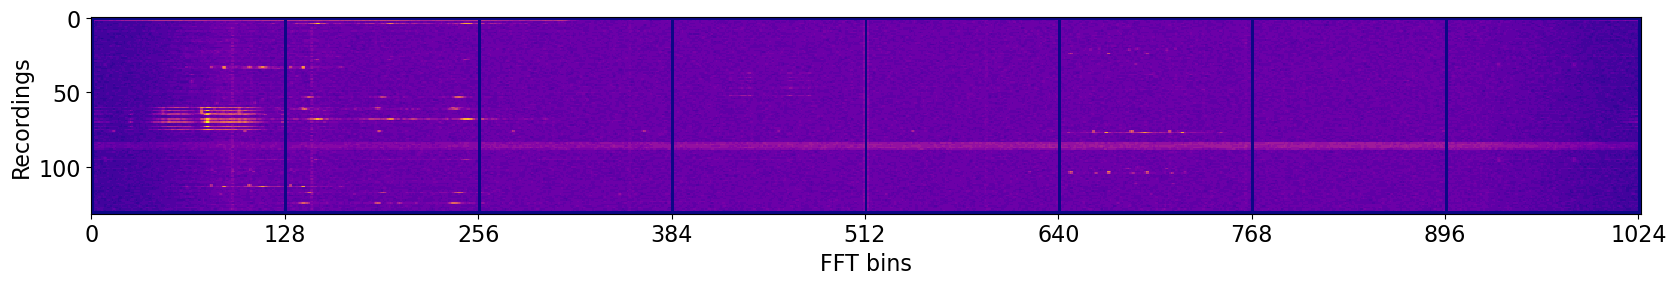

In [5]:
# Show multiple samples from the dataset
plt.rc('font', size=12)
plt.figure(figsize=(2, 2))
sample_index = 0
CMAP = 'plasma'
raw_dataset = SignalDatasetV2(window=IMG_SIZE, stride=IMG_STRIDE, 
                              limit=LIMIT_IMAGES, dataset_path=DATASET_PATH)

utls.plot_samples_grid(raw_dataset, 8, cmap=CMAP, padd=2)

In [6]:
# Assign labels using the Kmeans clustering and extract features 
# (full size 512x1 and PCA-reduced, PCA_DIMx1)
nn_input = raw_dataset
pseudo_labels, features, reduced = utls.cluster(pca, kmeans, model, nn_input, device, return_features=True)

extracting features: 100%|██████████| 313/313 [00:05<00:00, 53.06batch/s]


In [7]:
# Assign labels using the CNN. This is prefered over Kmeans because it provides the
# labels of the clusters formed at the end of the training.

pseudo_labels = utls.cnn_predict(raw_dataset, model, pin_memory, device)

# Extract features with NN and transform (reduce dimensionality) using PCA
features = utls.extract_features(model, raw_dataset, pin_memory, device)

# Remove axes of length one since the output of the AvgPoolLayer is 4 dimensional.
features = np.squeeze(features)

# Remove possible NaN and inf values.
features[~np.isfinite(features)] = 0

# Reduce feature space with PCA
reduced = pca.fit_transform(features)

# L2 normalization
norm = np.linalg.norm(reduced, axis=1)
reduced = reduced / norm[:, np.newaxis]

# Perform clustering/pseudo-labeling with KMeans
# Remove possible NaN and inf values.
reduced[~np.isfinite(reduced)] = 0


extracting features: 100%|██████████| 313/313 [00:04<00:00, 64.31batch/s]


In [8]:
# # Calculate clustering tendency and clustering quality metrics for 
# # different dimensionality features by adjusting the range.

# s_list = []
# db_list = []
# h_list = []
# for i in range(2, 40, 1):
    
#     print("PCA: ", i)

#     s_score = silhouette_score(reduced[:, 0:i], pseudo_labels, metric='euclidean')
#     db_score = davies_bouldin_score(reduced[:, 0:i], pseudo_labels)
#     h_score = hopkins(reduced[:, 0:i], sampling_size=1000)
#     h_list.append(h_score)
#     utls.plot_VAT(features, reduced[:, 0:i], 1000, NUM_CLASSES)
#     s_list.append(s_score)
#     db_list.append(db_score)
    
# # # Uncomment to save results
# # np.save('../results/output/s_scores_vgg.npy', np.array(s_list))
# # np.save('../results/output/db_scores_vgg.npy', np.array(db_list))
# # np.save('../results/output/h_scores_vgg.npy', np.array(h_list))

In [9]:
cluster_centers = utls.get_cluster_centers(pseudo_labels, reduced)
print(cluster_centers[0,:])
# print(kmeans.cluster_centers_[0,:])

[-0.08010664 -0.18329589  0.43973229 -0.28060502 -0.09763448 -0.15030386
  0.19682982 -0.0509051  -0.0633252   0.26014037  0.01712263 -0.20375193
  0.24188103  0.05029655 -0.03089463 -0.03369926 -0.13376894  0.09981389
  0.17786603 -0.03207748]


In [10]:
# # Uncomment for saving the results
# np.save('../results/output/features_rn.npy', features)
# np.save('../results/output/pca_reduced_features_rn.npy', reduced)
# np.save('../results/output/pseudo_labels_rn.npy', pseudo_labels)

In [11]:
# Select random subset of data.
used_data = reduced
# Define arrays for labels, samples and combined samples+labels
pseudo_labels_array = np.asarray(pseudo_labels)
ns_per_cluster = 1000
num_samples = KMEANS_CLUSTERS*ns_per_cluster
full_samples = np.empty((ns_per_cluster*KMEANS_CLUSTERS, used_data.shape[1]))
full_labels = np.empty((ns_per_cluster*KMEANS_CLUSTERS))
full_data = np.zeros((ns_per_cluster*KMEANS_CLUSTERS, full_samples.shape[1]+1), dtype=float)
selected_indices = np.empty((1, ns_per_cluster), dtype=int)

# From each cluster, take first ns_per_cluster-samples and 
for c in range(KMEANS_CLUSTERS):
  
    samples_indices = np.where(pseudo_labels_array==c)

    # Select random indices of the samples from given cluster.
    for i in range(ns_per_cluster):
        # selected_indices.append(random.randint(0, len(samples_indices)))
        selected_indices[0][i] = random.randint(0, len(samples_indices[0])-1)

    cluster_labels = pseudo_labels_array[samples_indices[0][selected_indices[0]]]
    cluster_samples = used_data[samples_indices[0][selected_indices[0]], :]
    full_labels[c*ns_per_cluster:(c+1)*ns_per_cluster] = cluster_labels[0:ns_per_cluster]
    full_samples[c*ns_per_cluster:(c+1)*ns_per_cluster, :] = cluster_samples

full_data[:, full_samples.shape[1]] = np.copy(full_labels)
full_data[0:num_samples, 0:full_samples.shape[1]] = np.copy(full_samples)
full_data_list = full_data.tolist()
df_full_data = pd.DataFrame(data=full_data_list,
          index=[i for i in range(full_data.shape[0])],
          columns=['f'+str(i) for i in range(full_data.shape[1])])

plt.figure(figsize=(20, 10))
df_full_data.head(4)

f0        f1        f2        f3        f4        f5        f6  \
0 -0.004985 -0.240377  0.376231 -0.319328  0.059279 -0.240207  0.352601   
1 -0.124837 -0.273606  0.448066 -0.164501 -0.105062 -0.149756  0.305968   
2  0.029431 -0.187313  0.517330 -0.408406 -0.352772 -0.118883 -0.033621   
3 -0.026574 -0.213129  0.472334 -0.408371  0.058501  0.002460  0.275088   

         f7        f8        f9  ...       f11       f12       f13       f14  \
0  0.026403  0.033376  0.361105  ... -0.160486  0.257685  0.251585 -0.008377   
1  0.128652 -0.173096  0.326759  ... -0.288174  0.464515  0.146250 -0.119031   
2 -0.171281 -0.101660  0.256348  ... -0.217298  0.178055  0.086739 -0.027906   
3 -0.147020 -0.185481  0.239561  ... -0.367037  0.200911 -0.052238 -0.114788   

        f15       f16       f17       f18       f19  f20  
0 -0.114904 -0.152554  0.239386  0.120018 -0.310136  0.0  
1 -0.046813 -0.128750  0.004178 -0.154794  0.052262  0.0  
2  0.125104 -0.193072  0.049998  0.374579 -0.025748  0.0  
3 -0.146278 -0.160217  0.059338  0.292211 -0.047710  0.0  

[4 rows x 21 columns]

<Figure size 2000x1000 with 0 Axes>

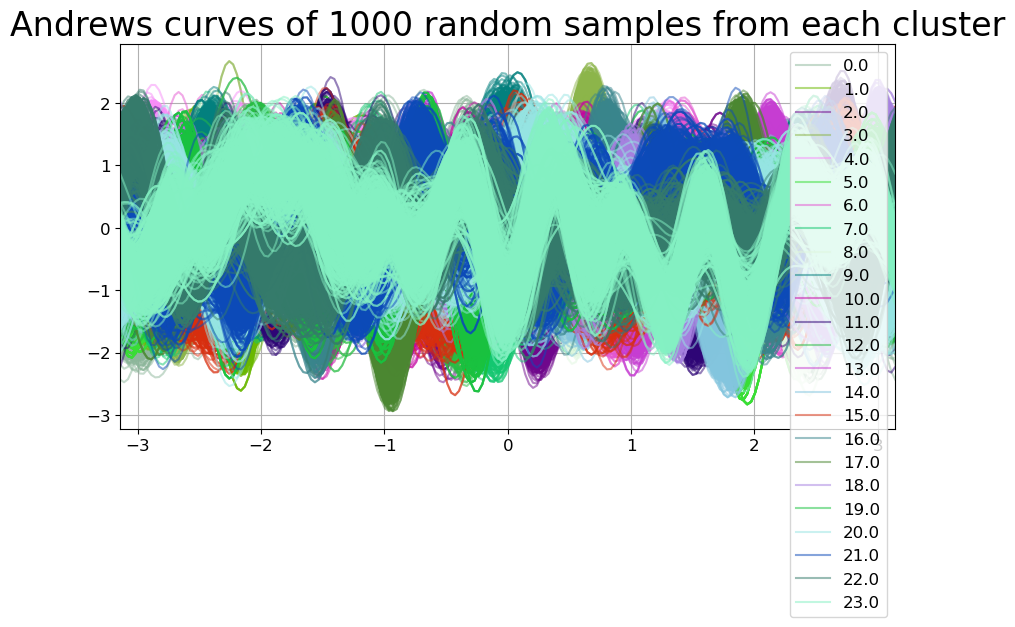

In [12]:
# Compute and show Andrews curves. 
# Change the class column corresponding to the number of PCA components used.
plt.figure(figsize=(10, 5))
plt.rc('font', size=12)
# "class_column" should be selected appropriate to the number of PCA used (20 for 20 PCA).
pd.plotting.andrews_curves(df_full_data, class_column='f20', alpha=0.5)
plt.title("Andrews curves of " + str(ns_per_cluster) + " random samples from each cluster", size=24)
plt.savefig(RESULTS_PATH + "andrews c" + str(KMEANS_CLUSTERS) + ".png", facecolor='w', bbox_inches='tight', pad_inches = 0)

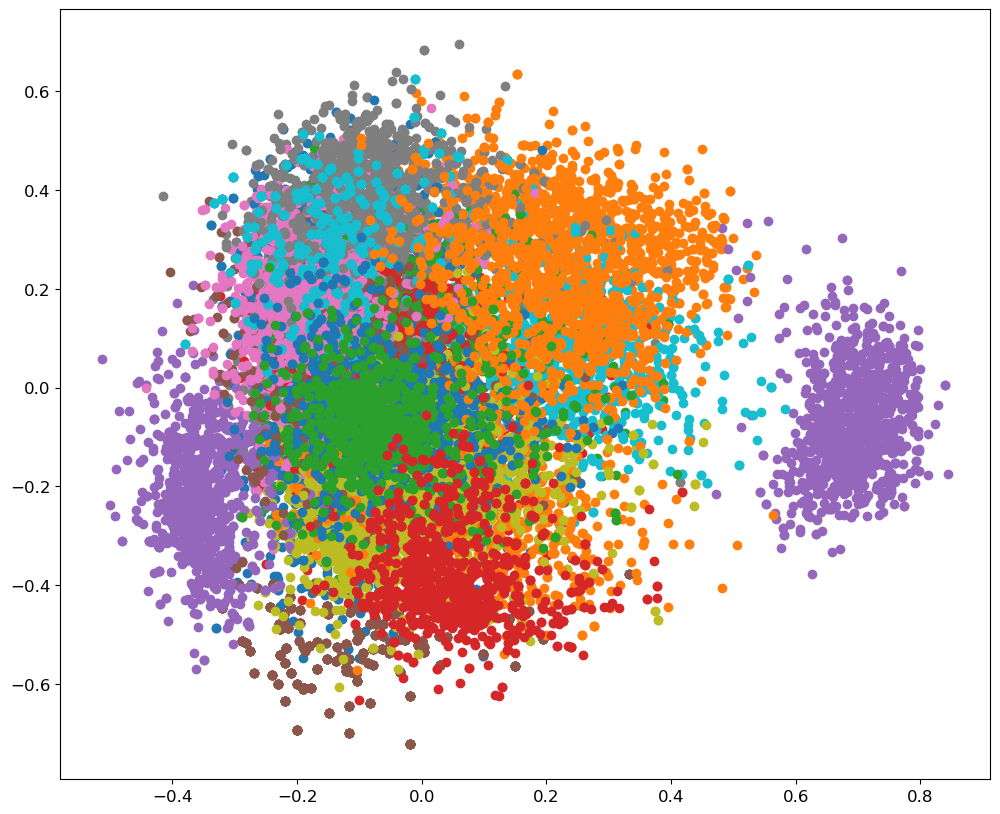

In [13]:
# Show scatter plot of the first 2 principal components of 1000 random samples by each cluster.
plt.figure(figsize=(12, 10))
plt.rc('font', size=12)
dim1 = 0
dim2 = 1
legend_str = str()
legend_list = []
# From each cluster, take first ns_per_cluster-samples
for c in range(NUM_CLASSES):
    plt.scatter(full_data[c*ns_per_cluster:(c+1)*ns_per_cluster, dim1], full_data[c*ns_per_cluster:(c+1)*ns_per_cluster, dim2])
    legend_list.append(str(c))


/home/jovyan/working folder/code/SSLUtils.py:171: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(50, 25))


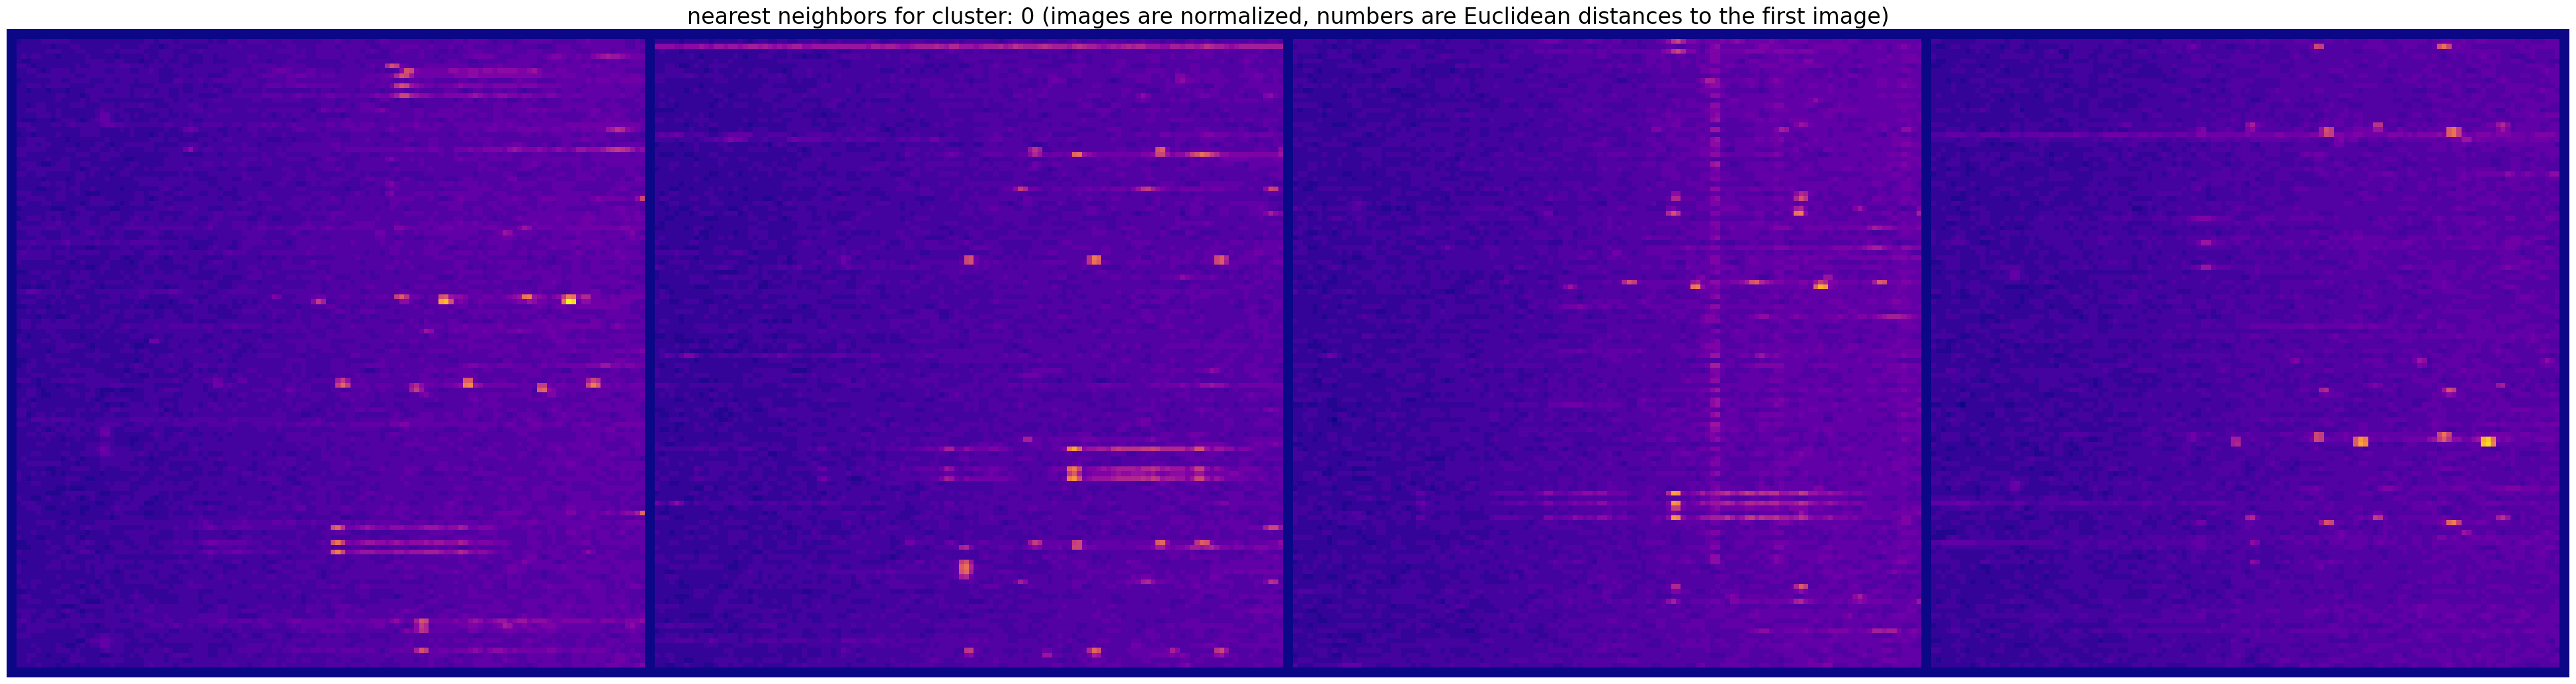

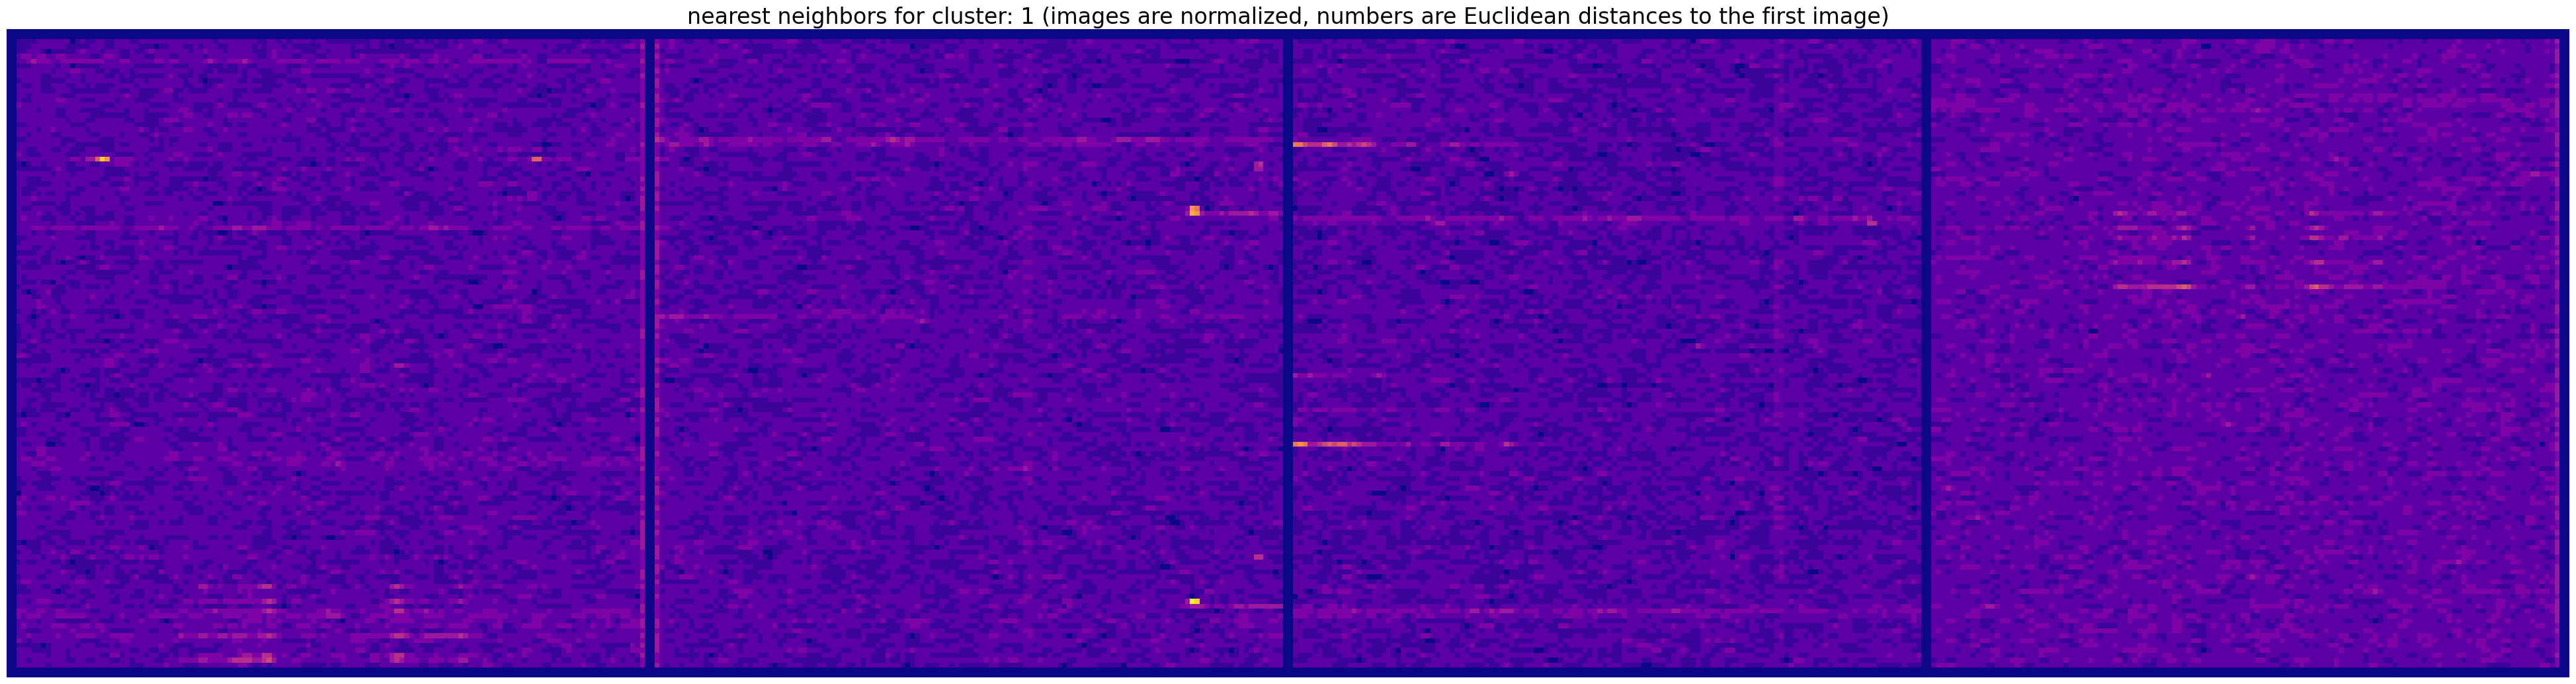

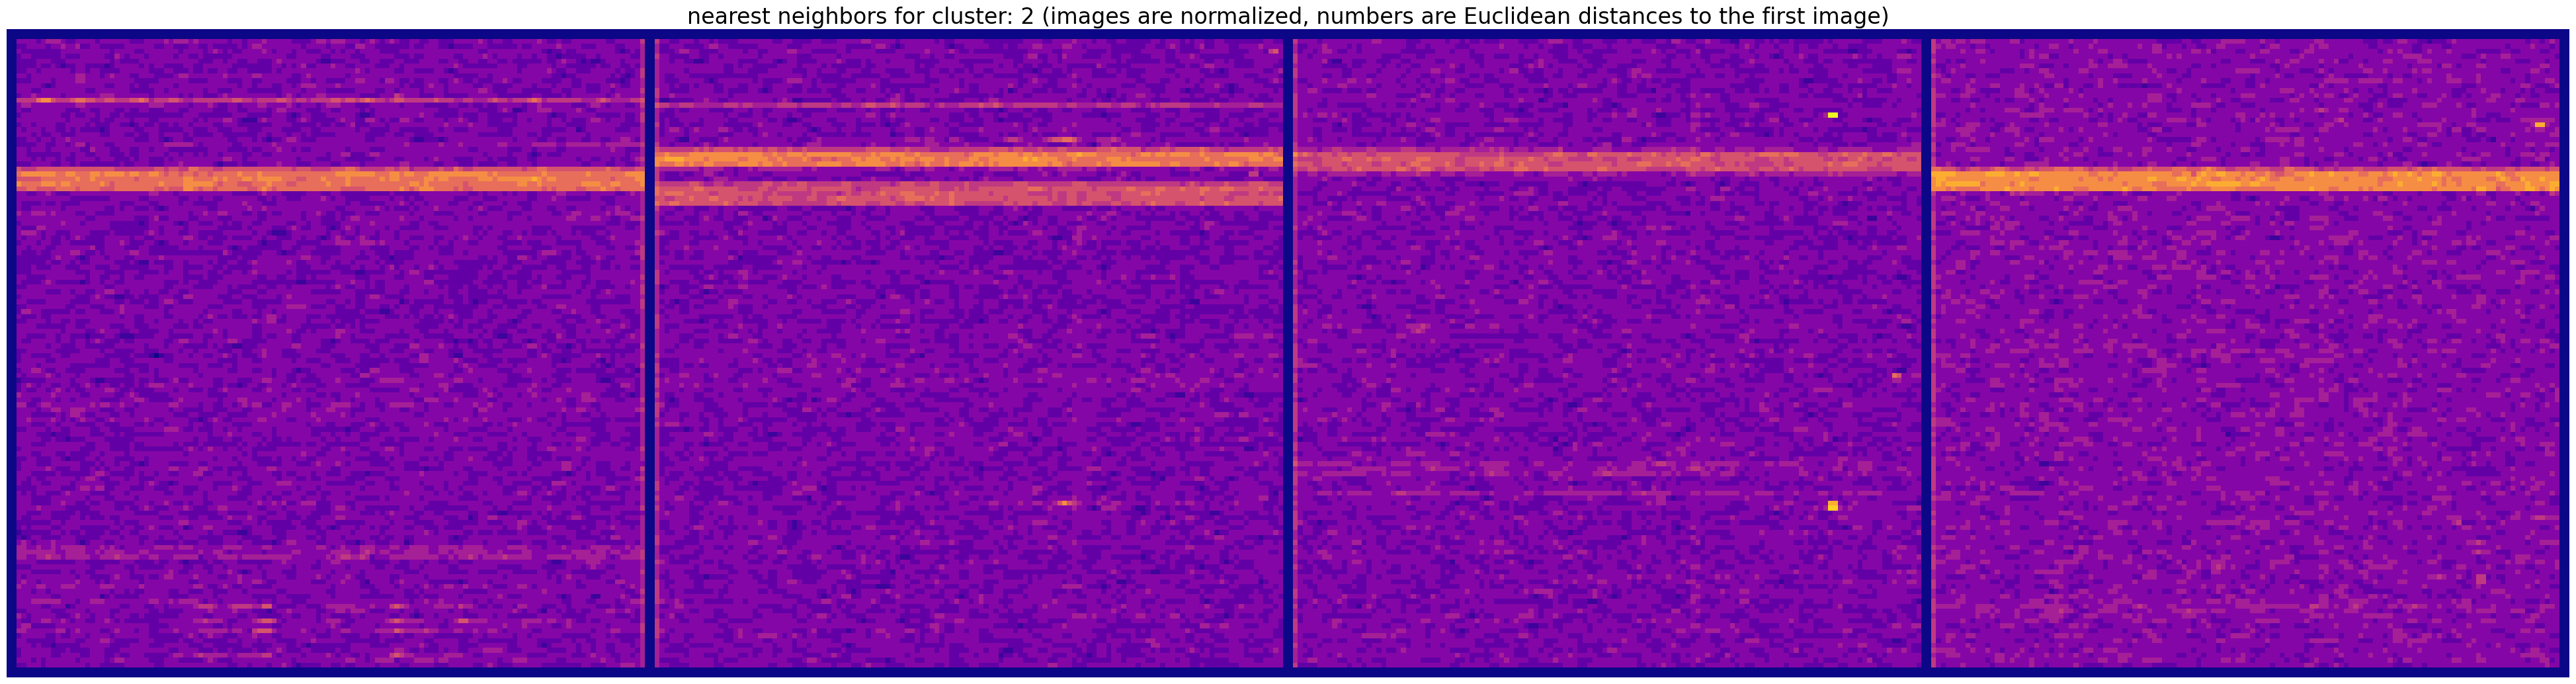

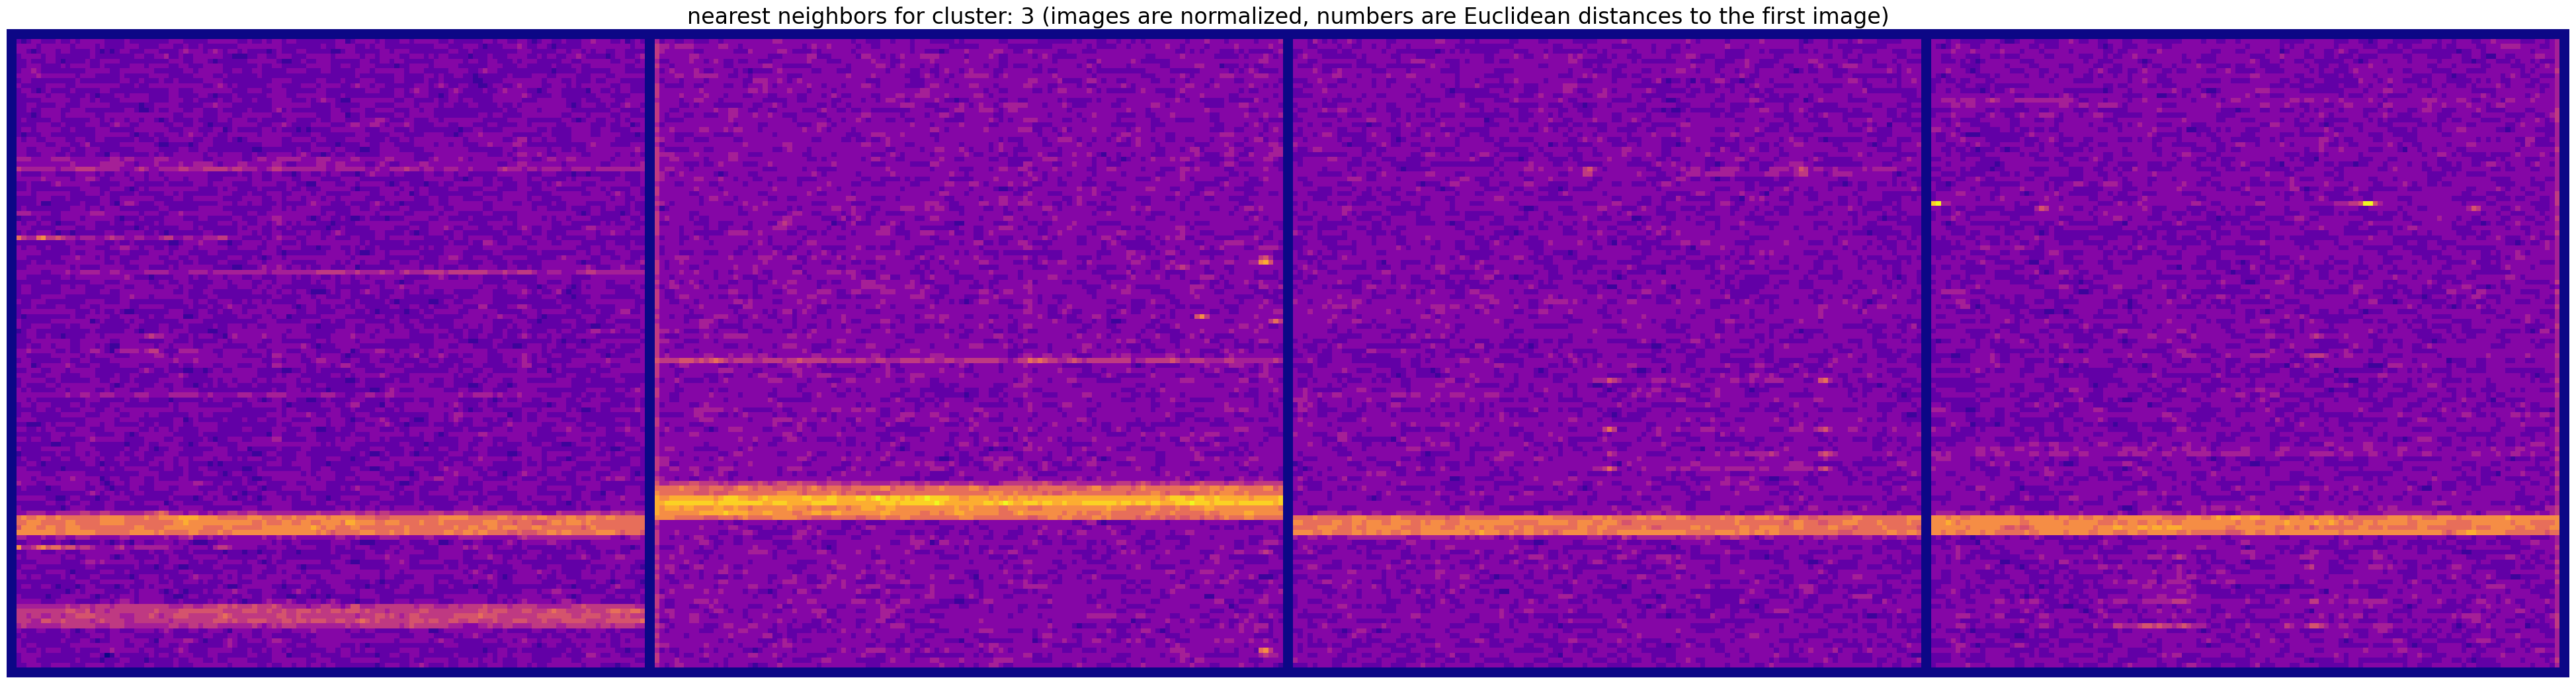

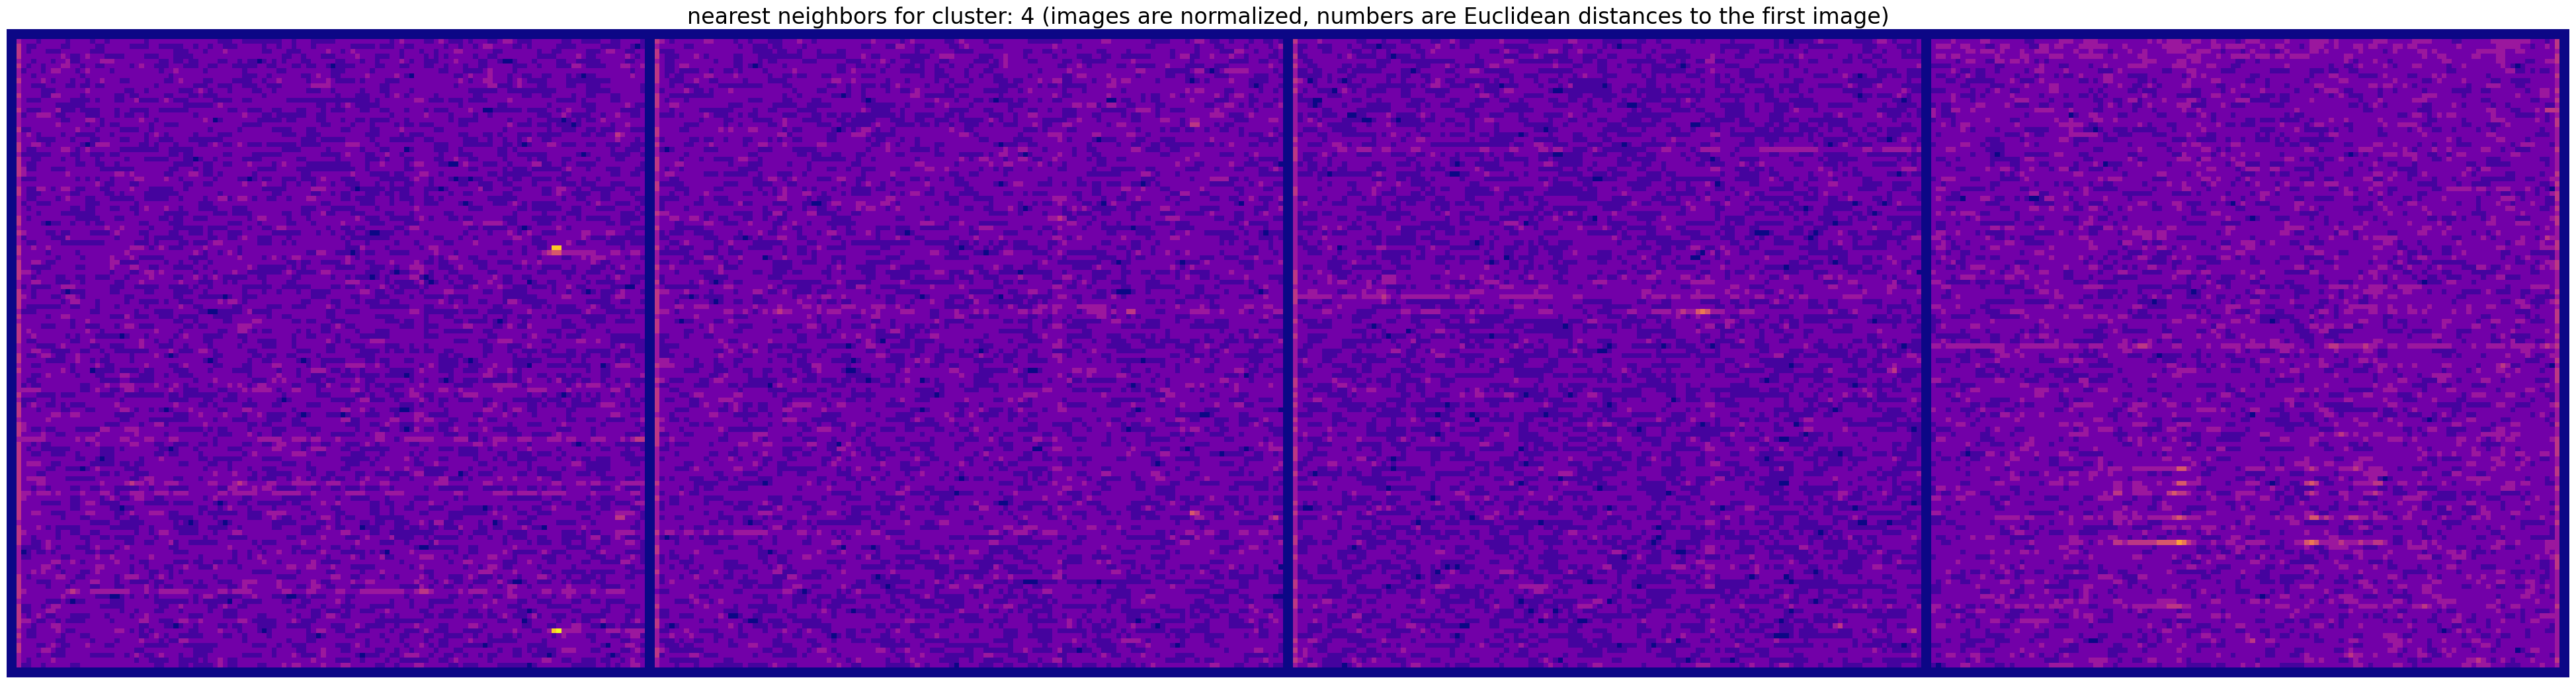

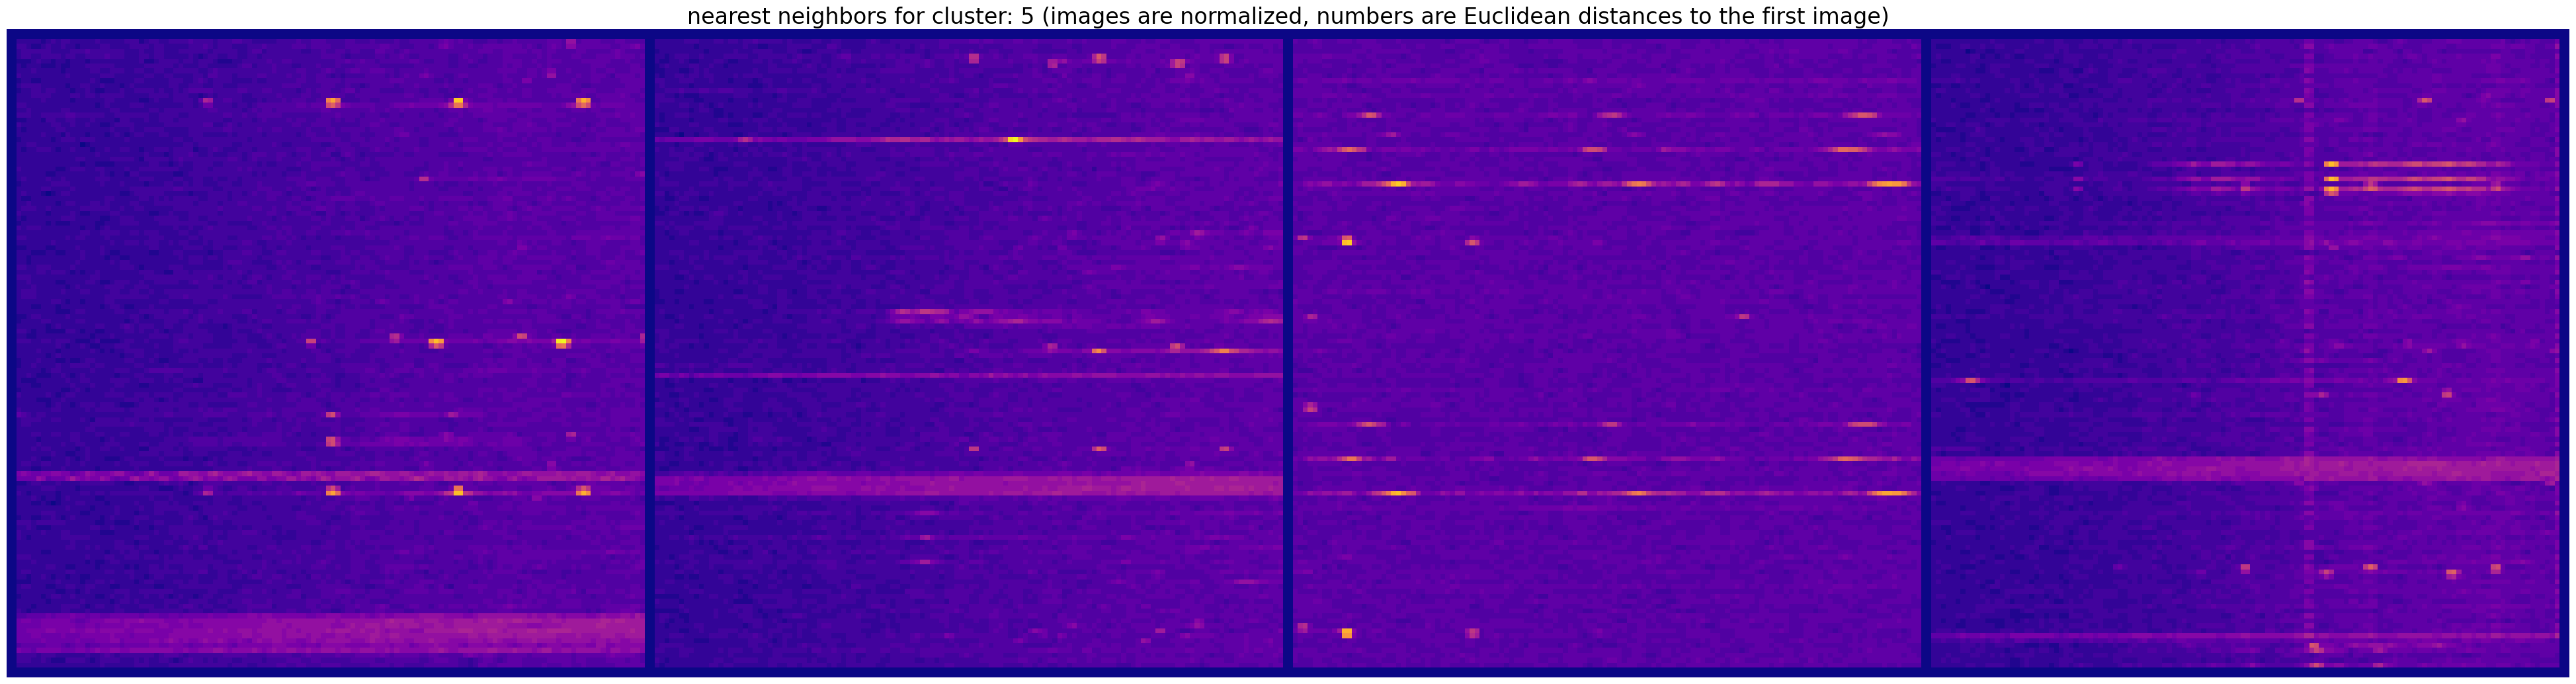

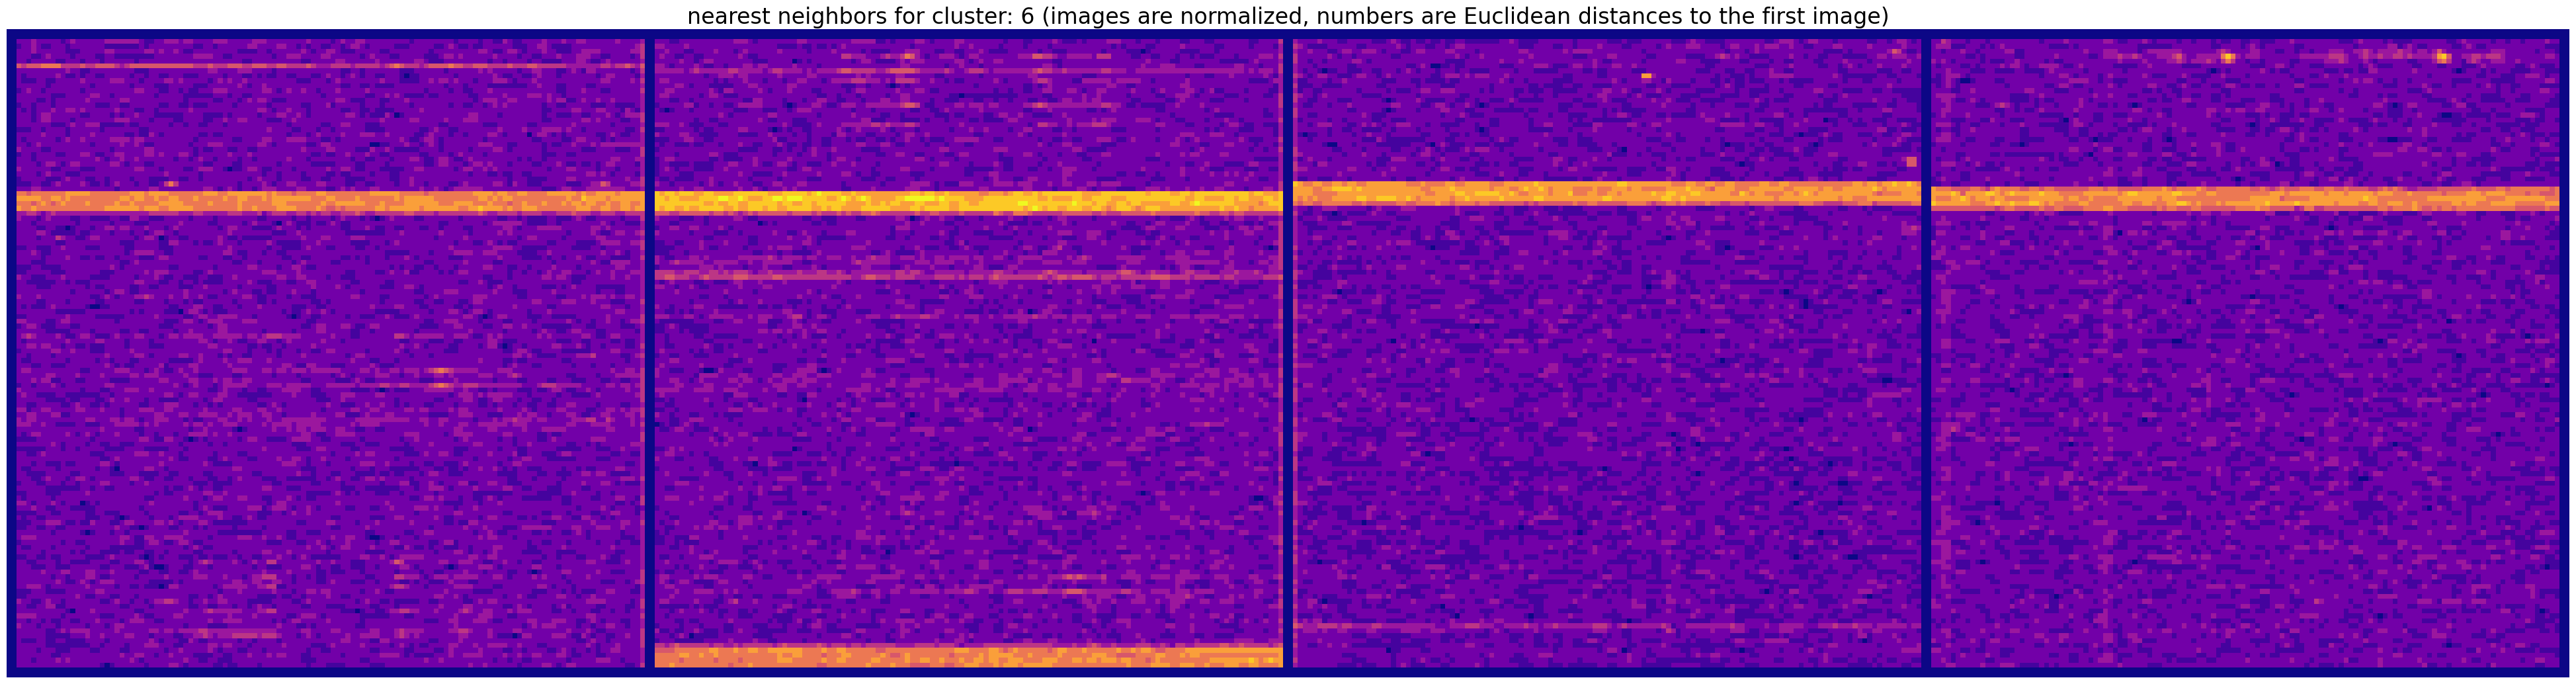

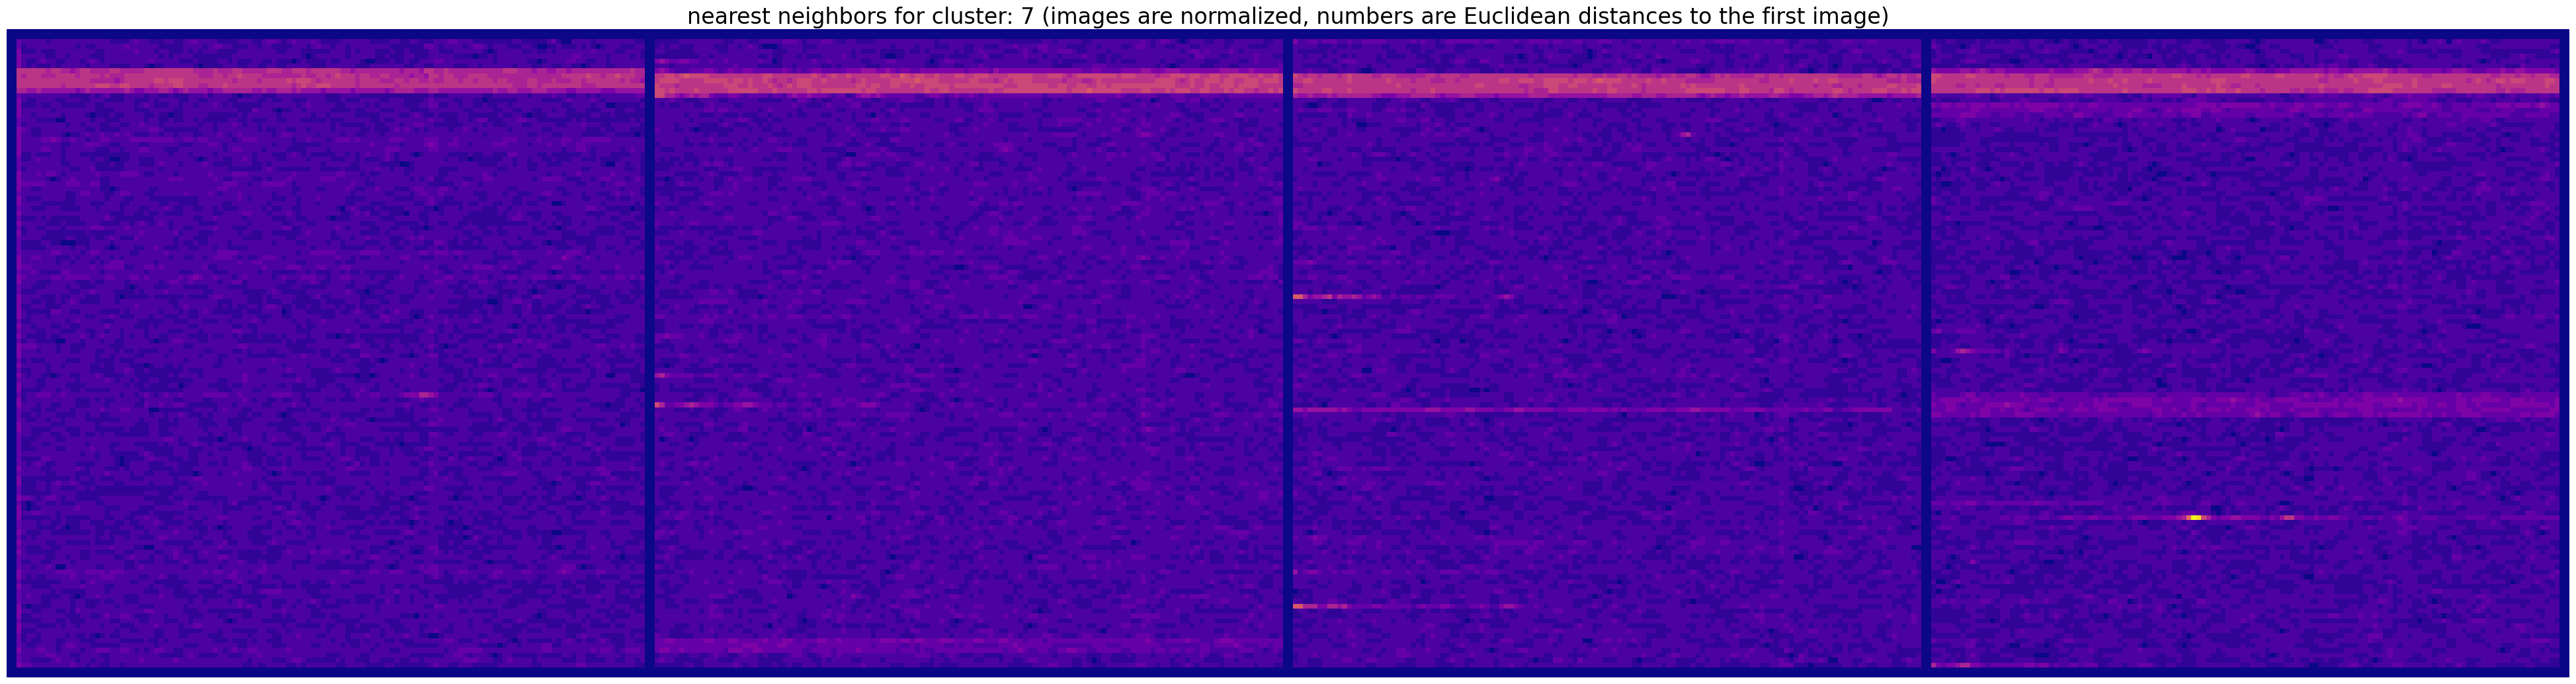

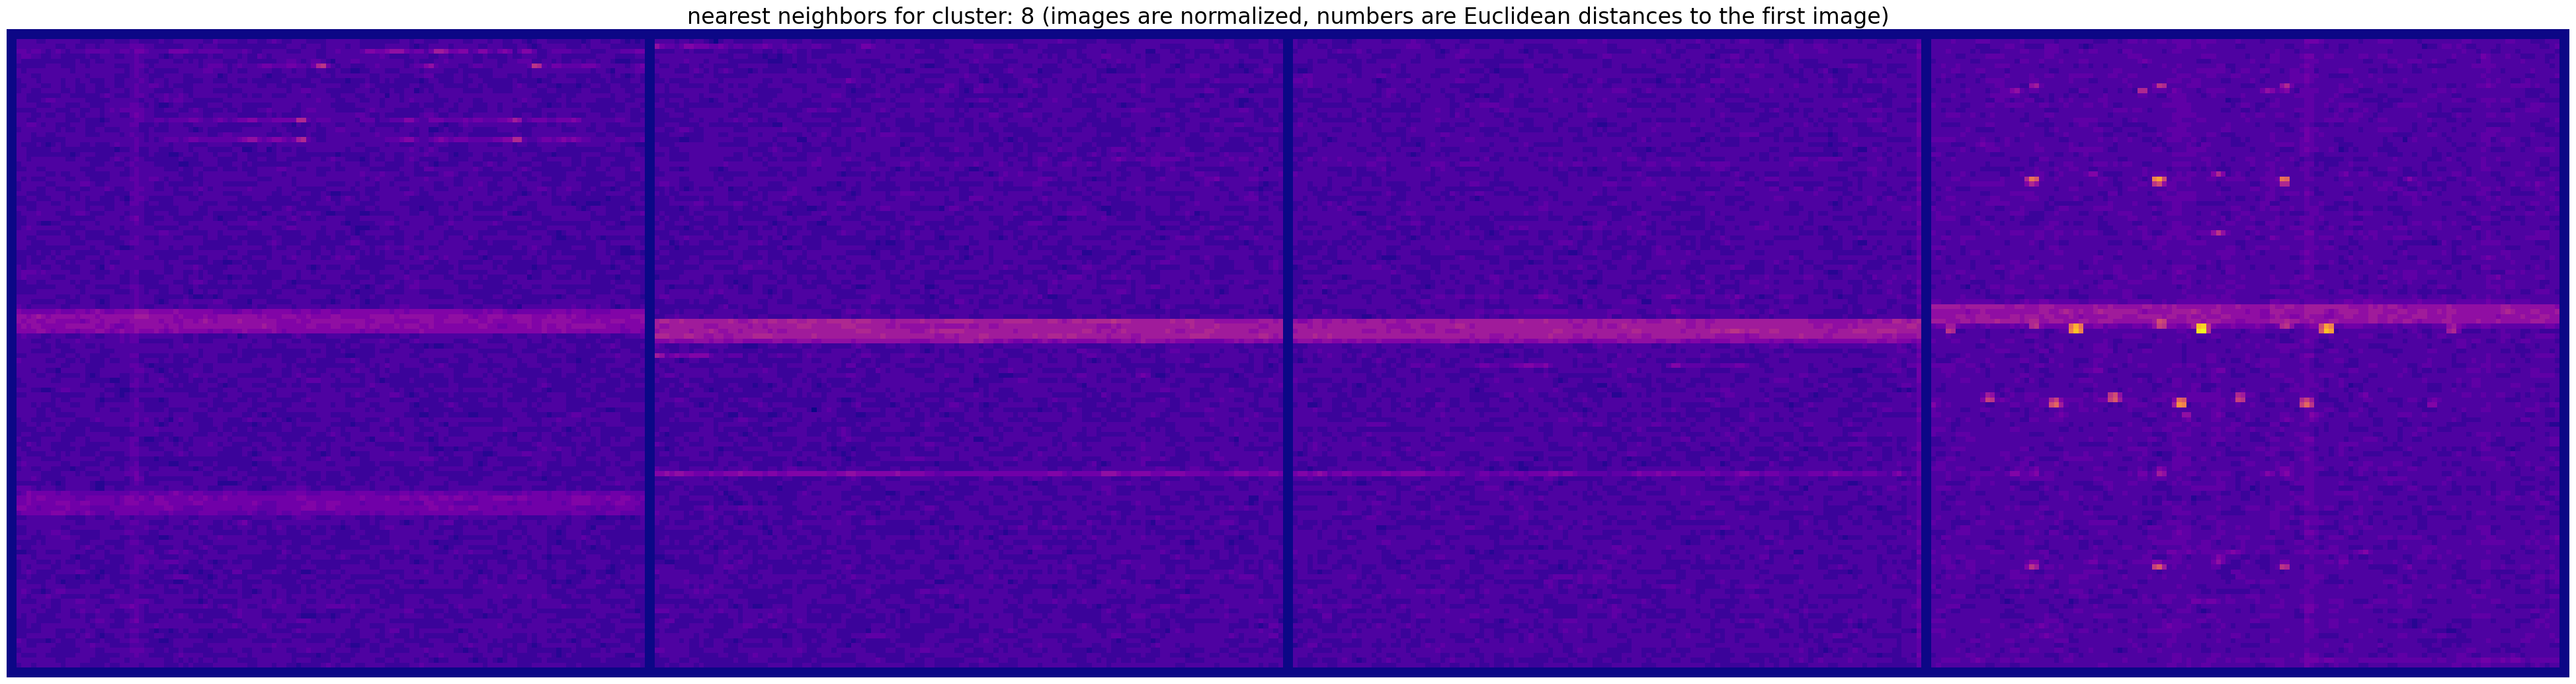

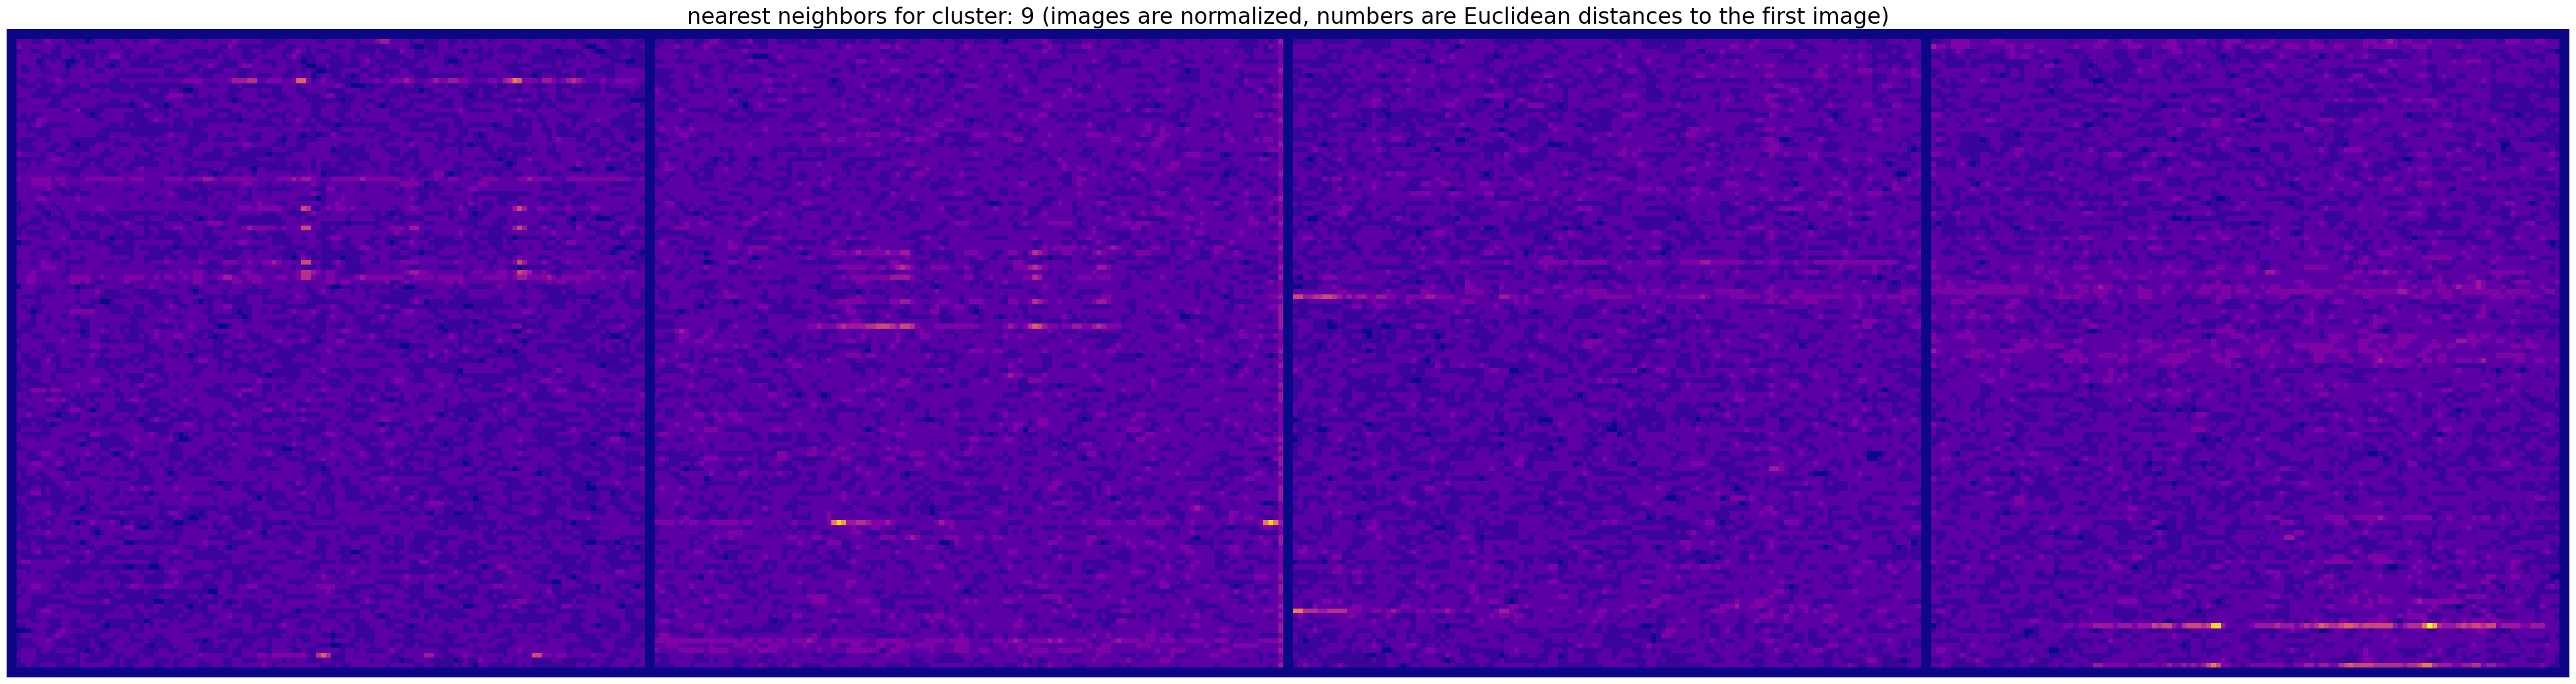

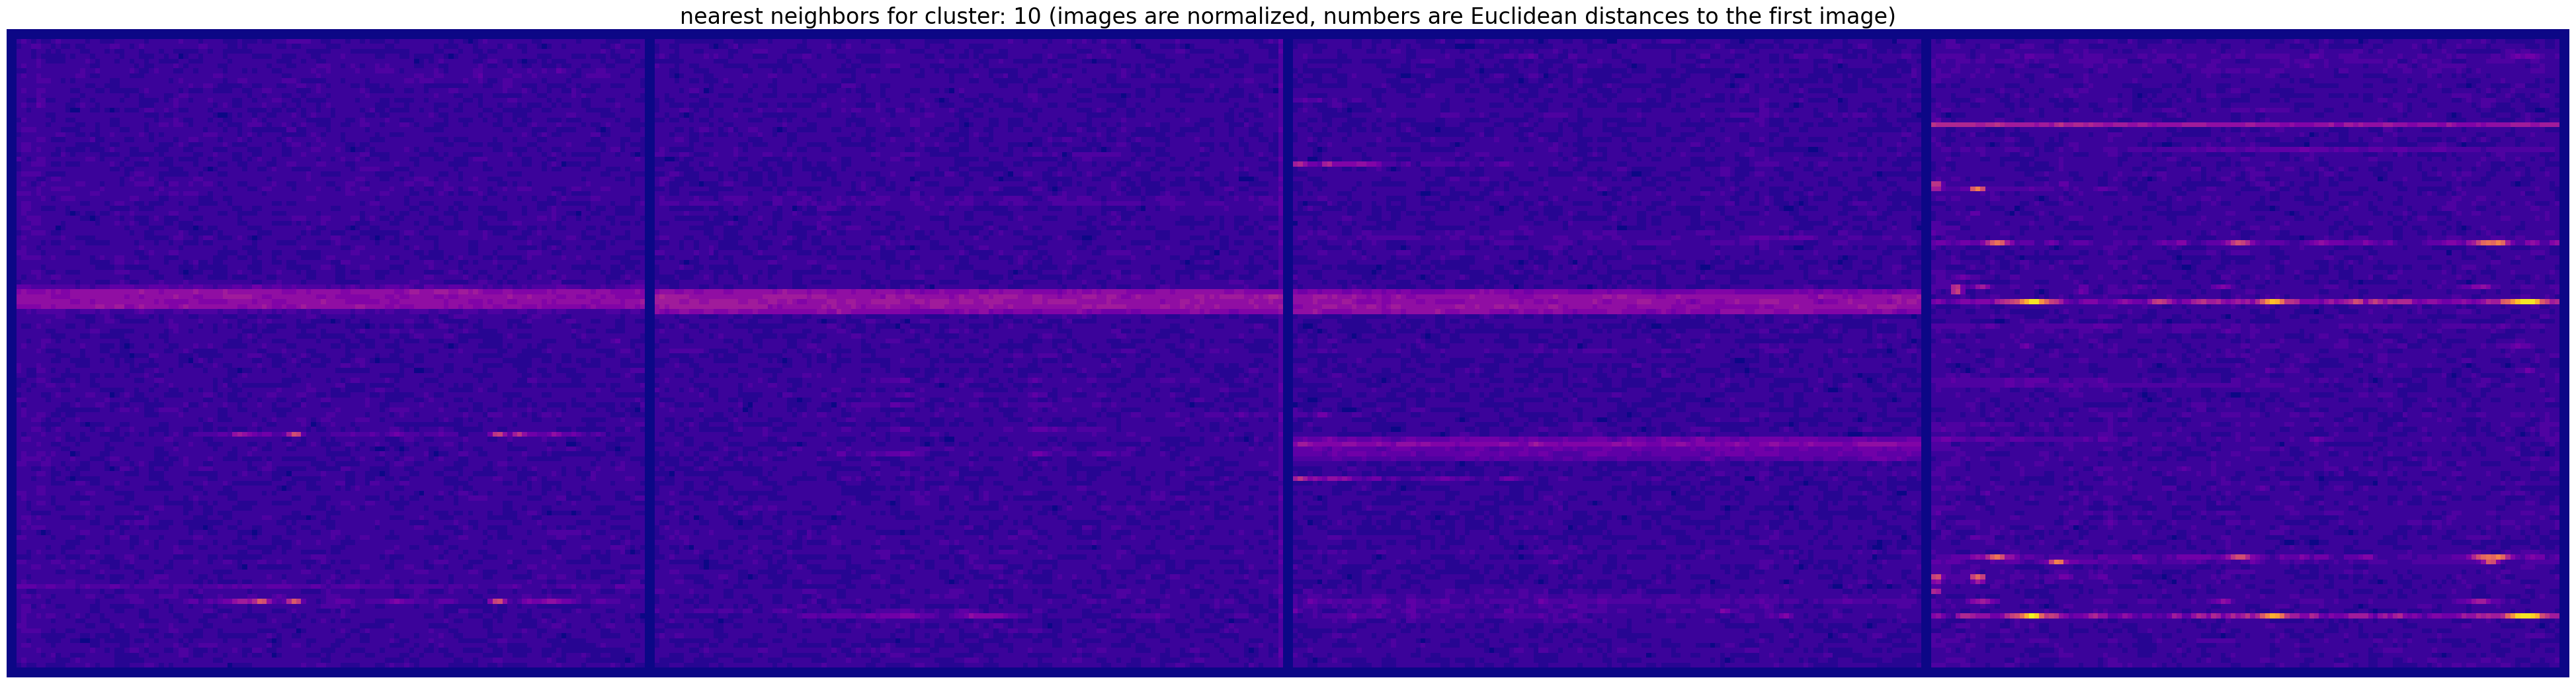

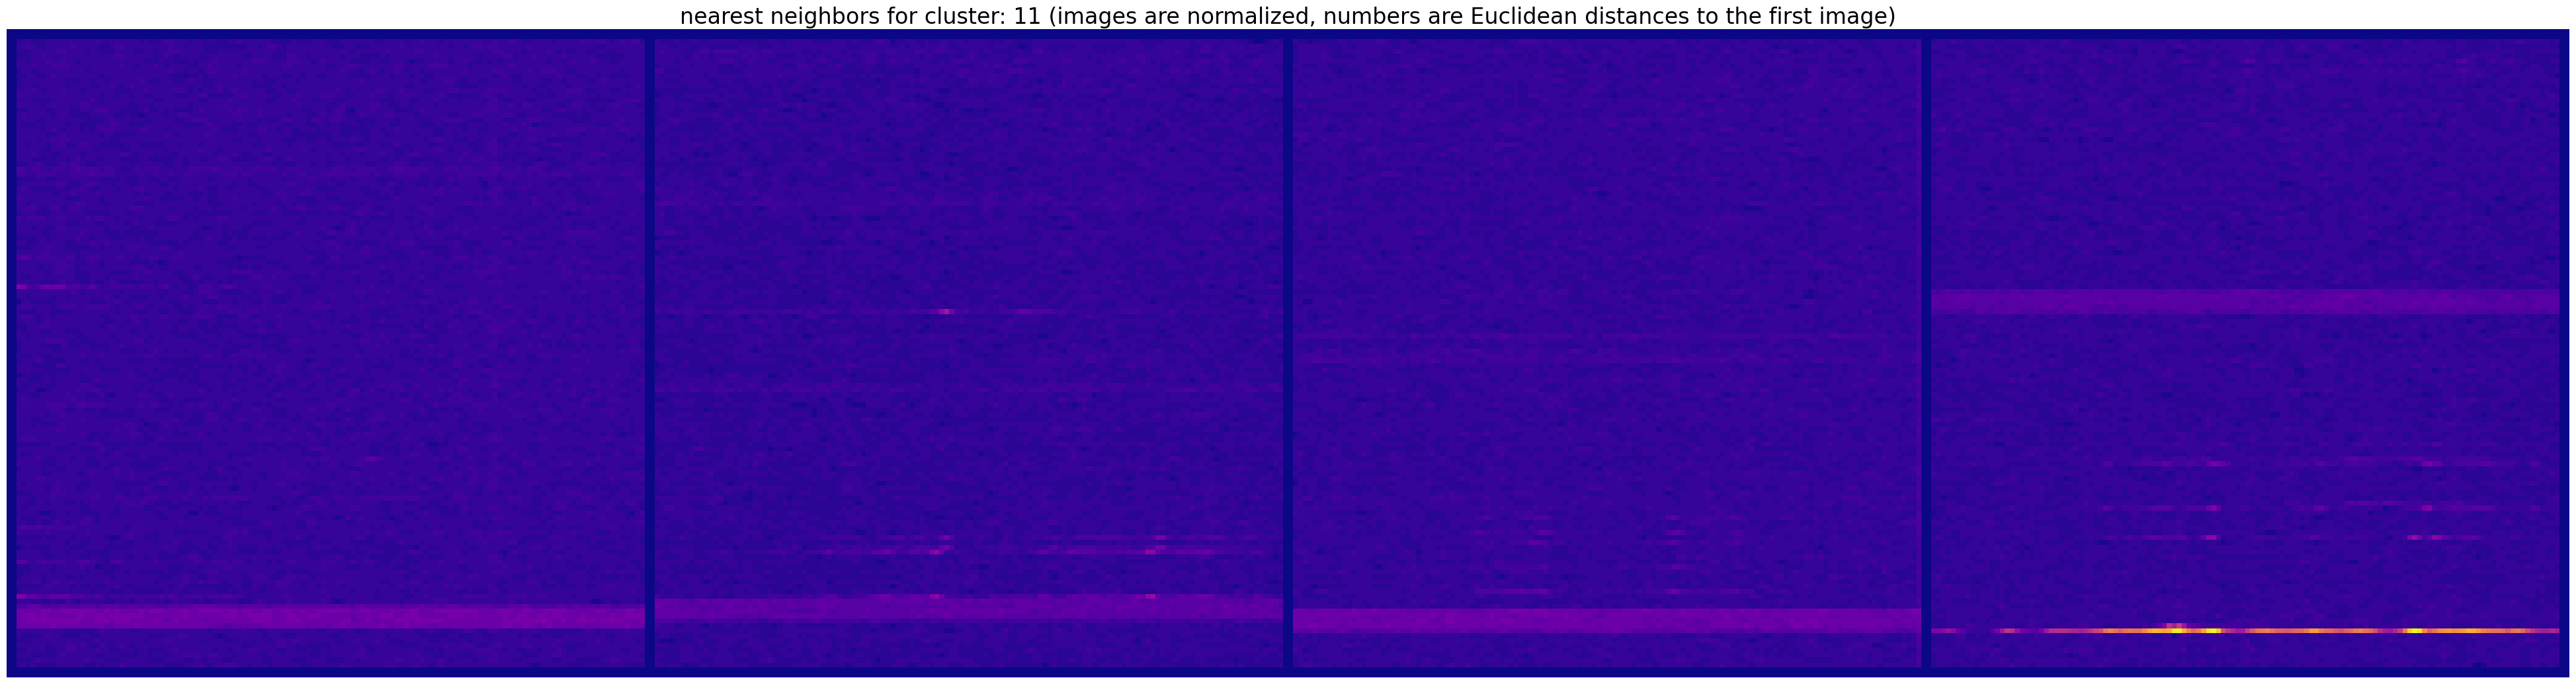

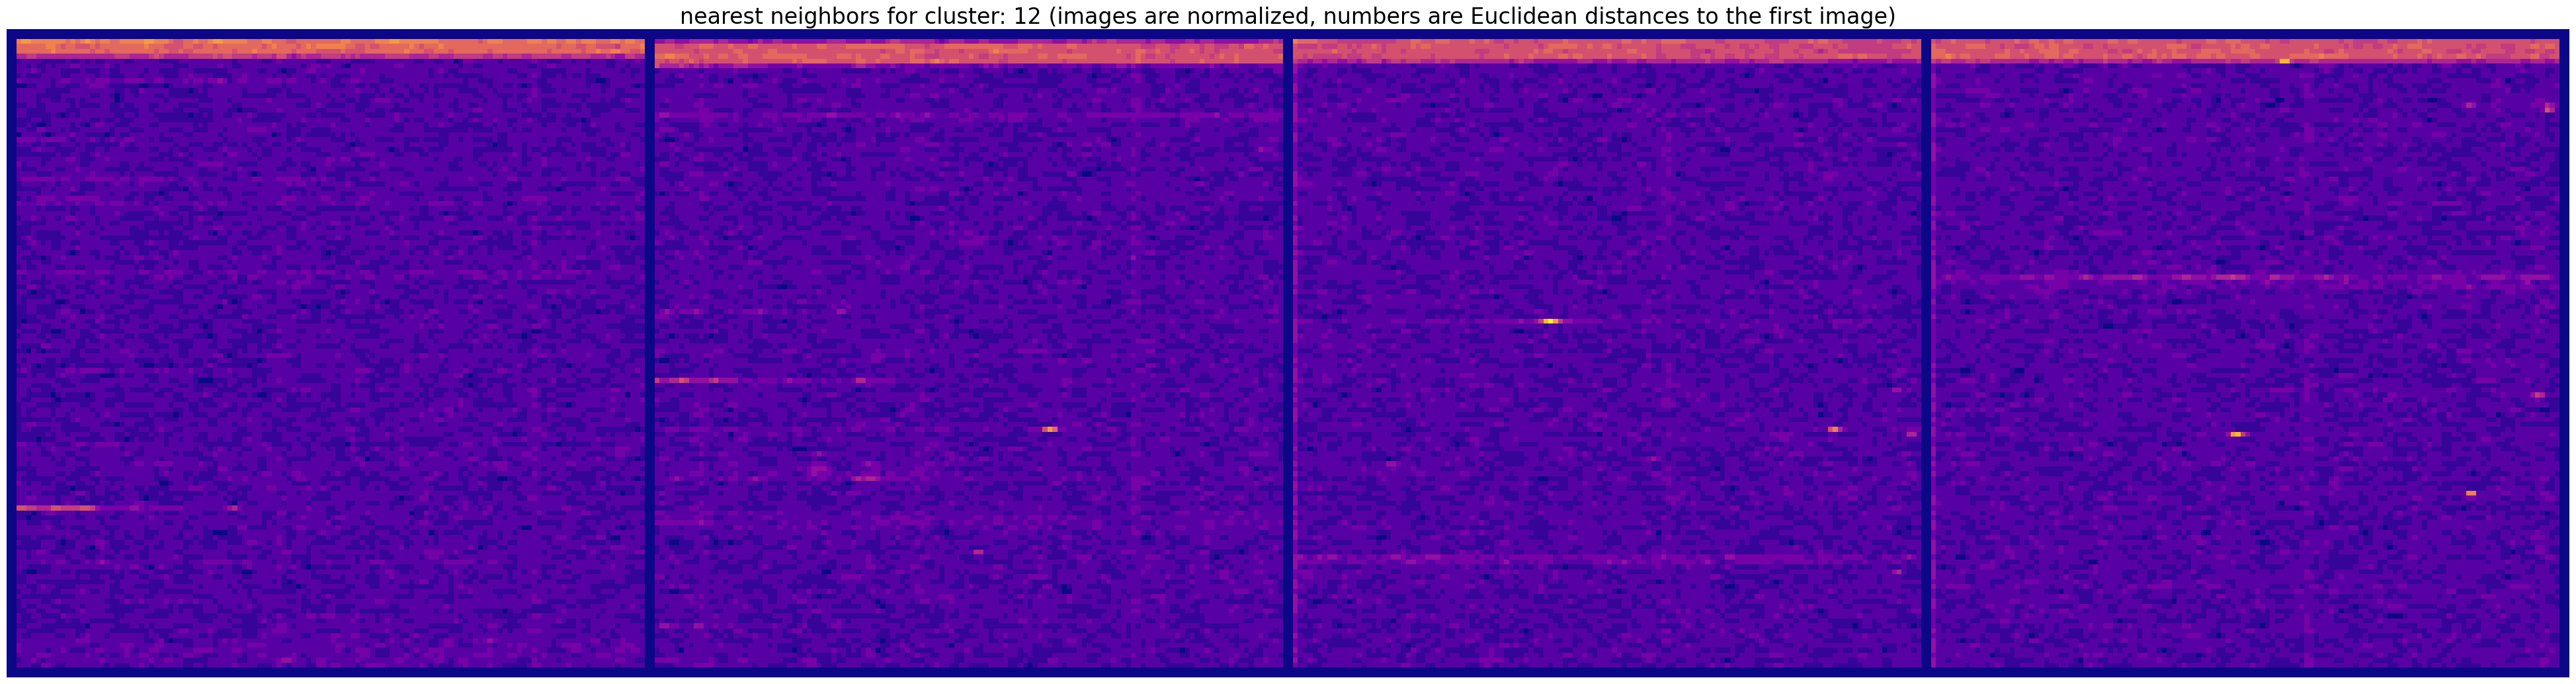

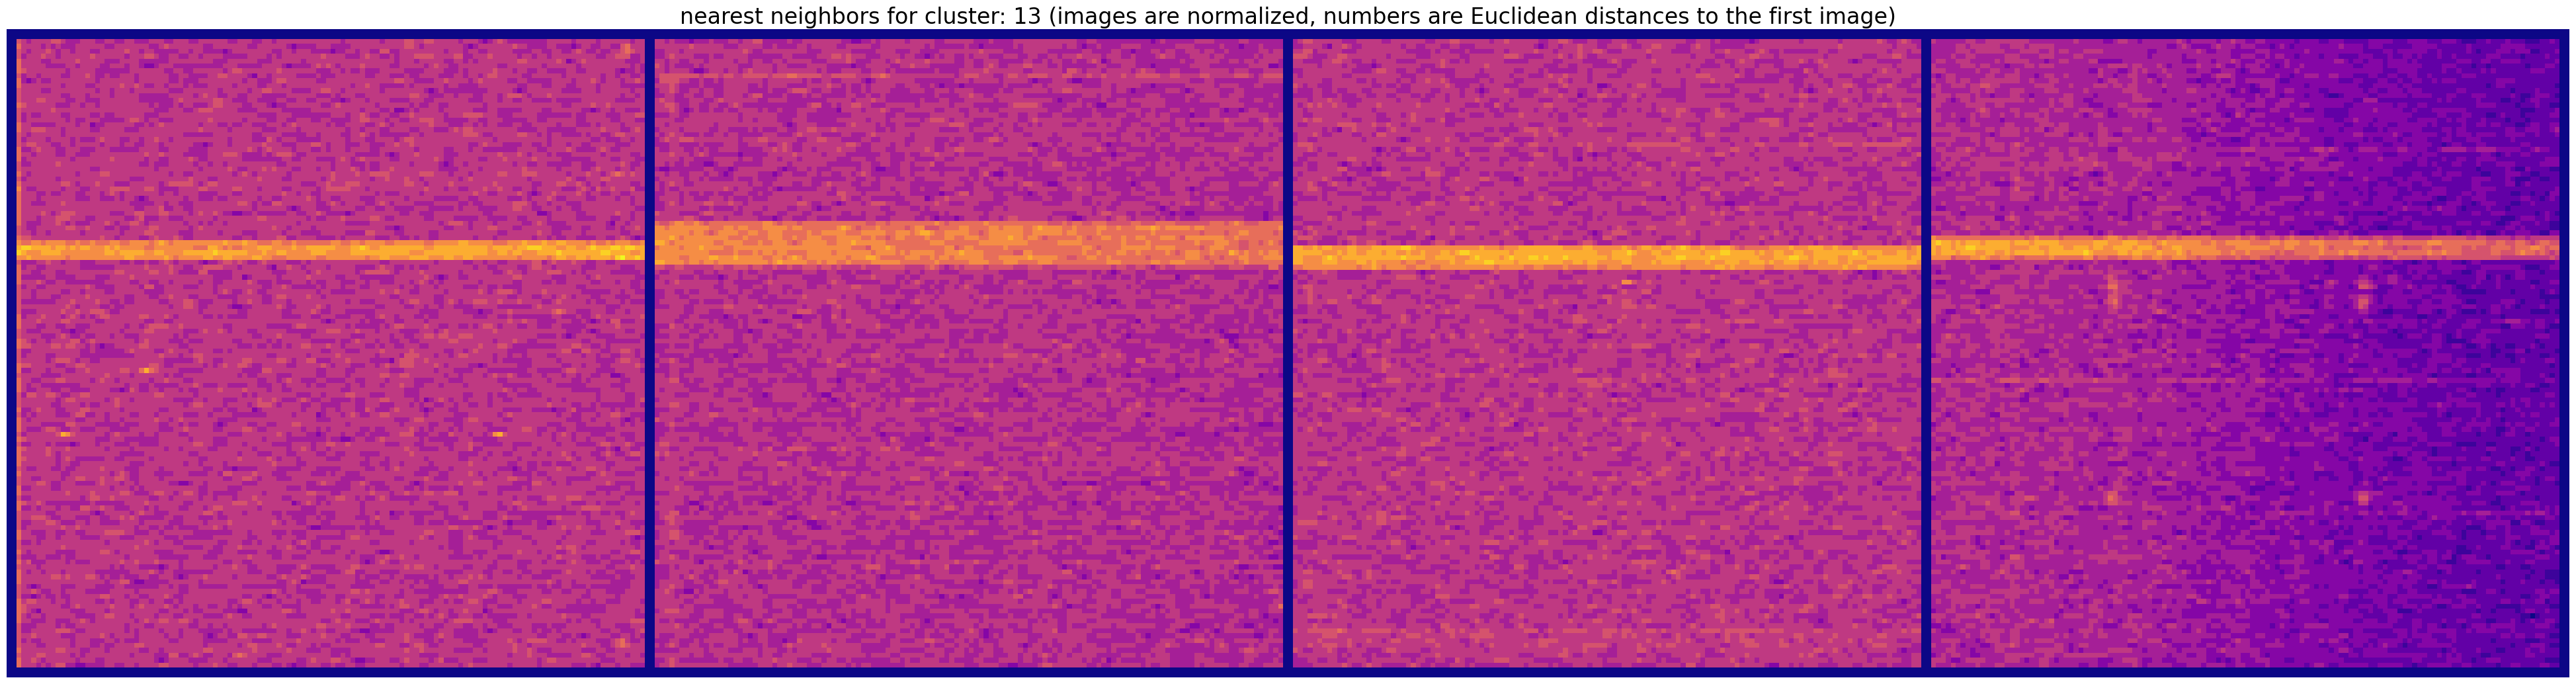

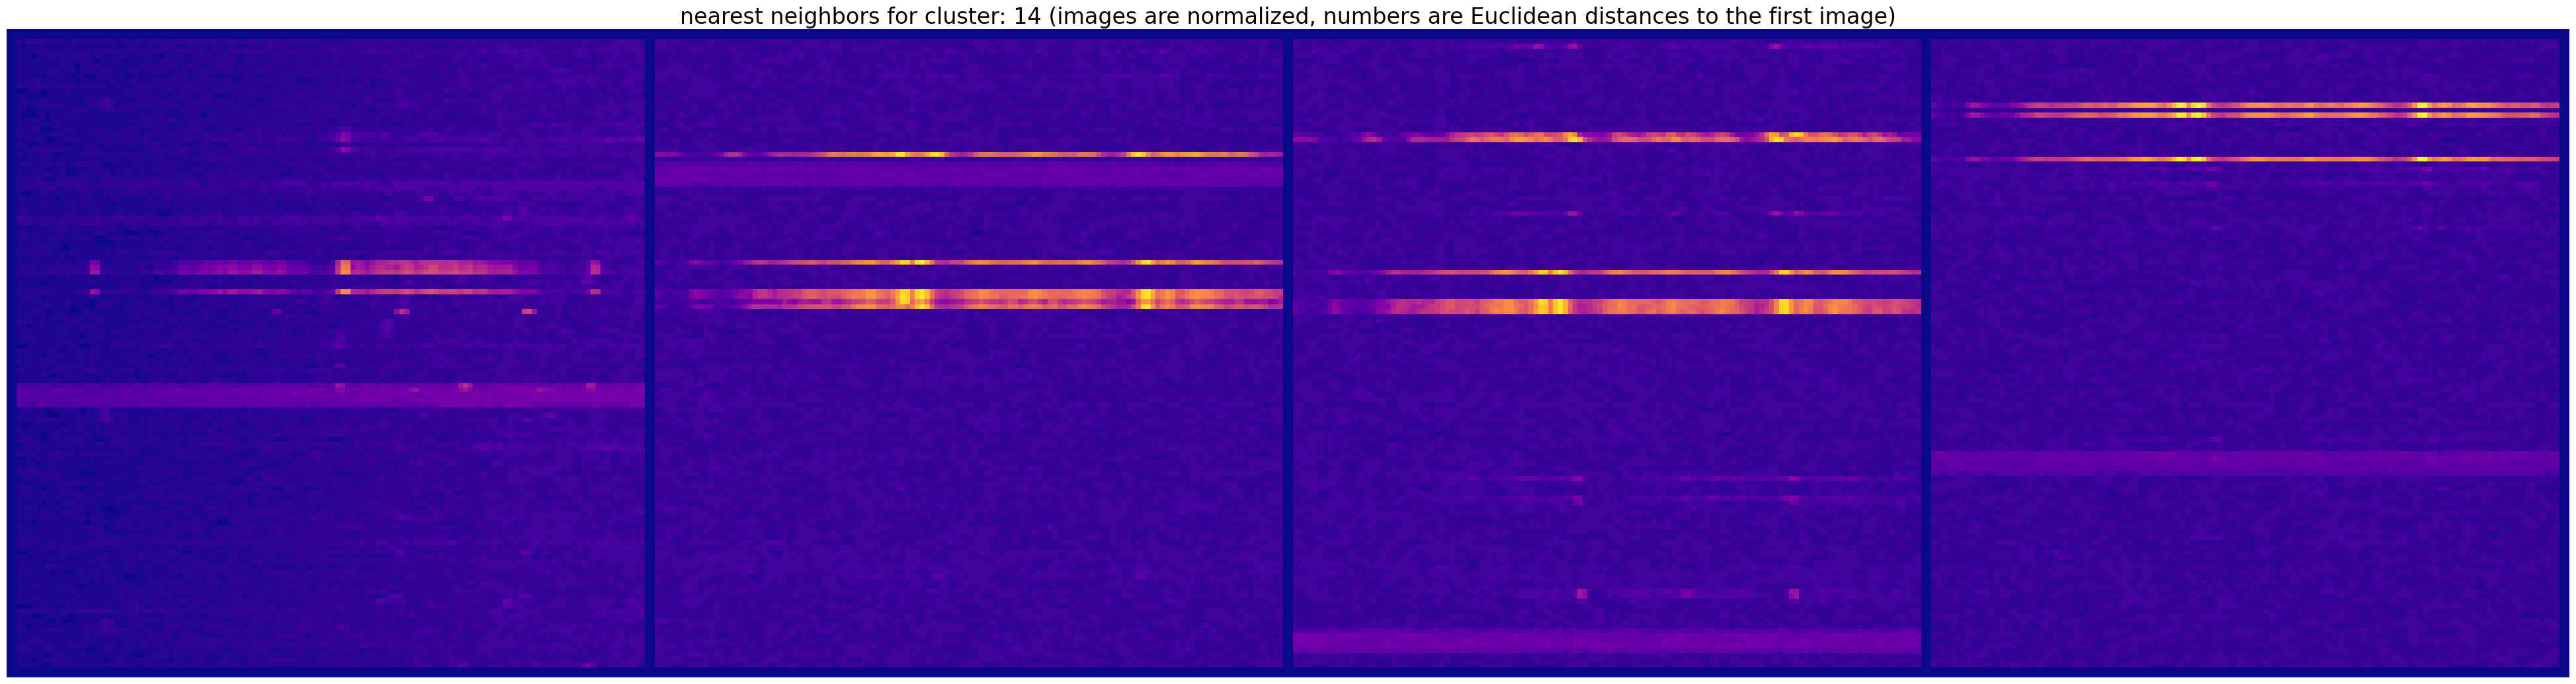

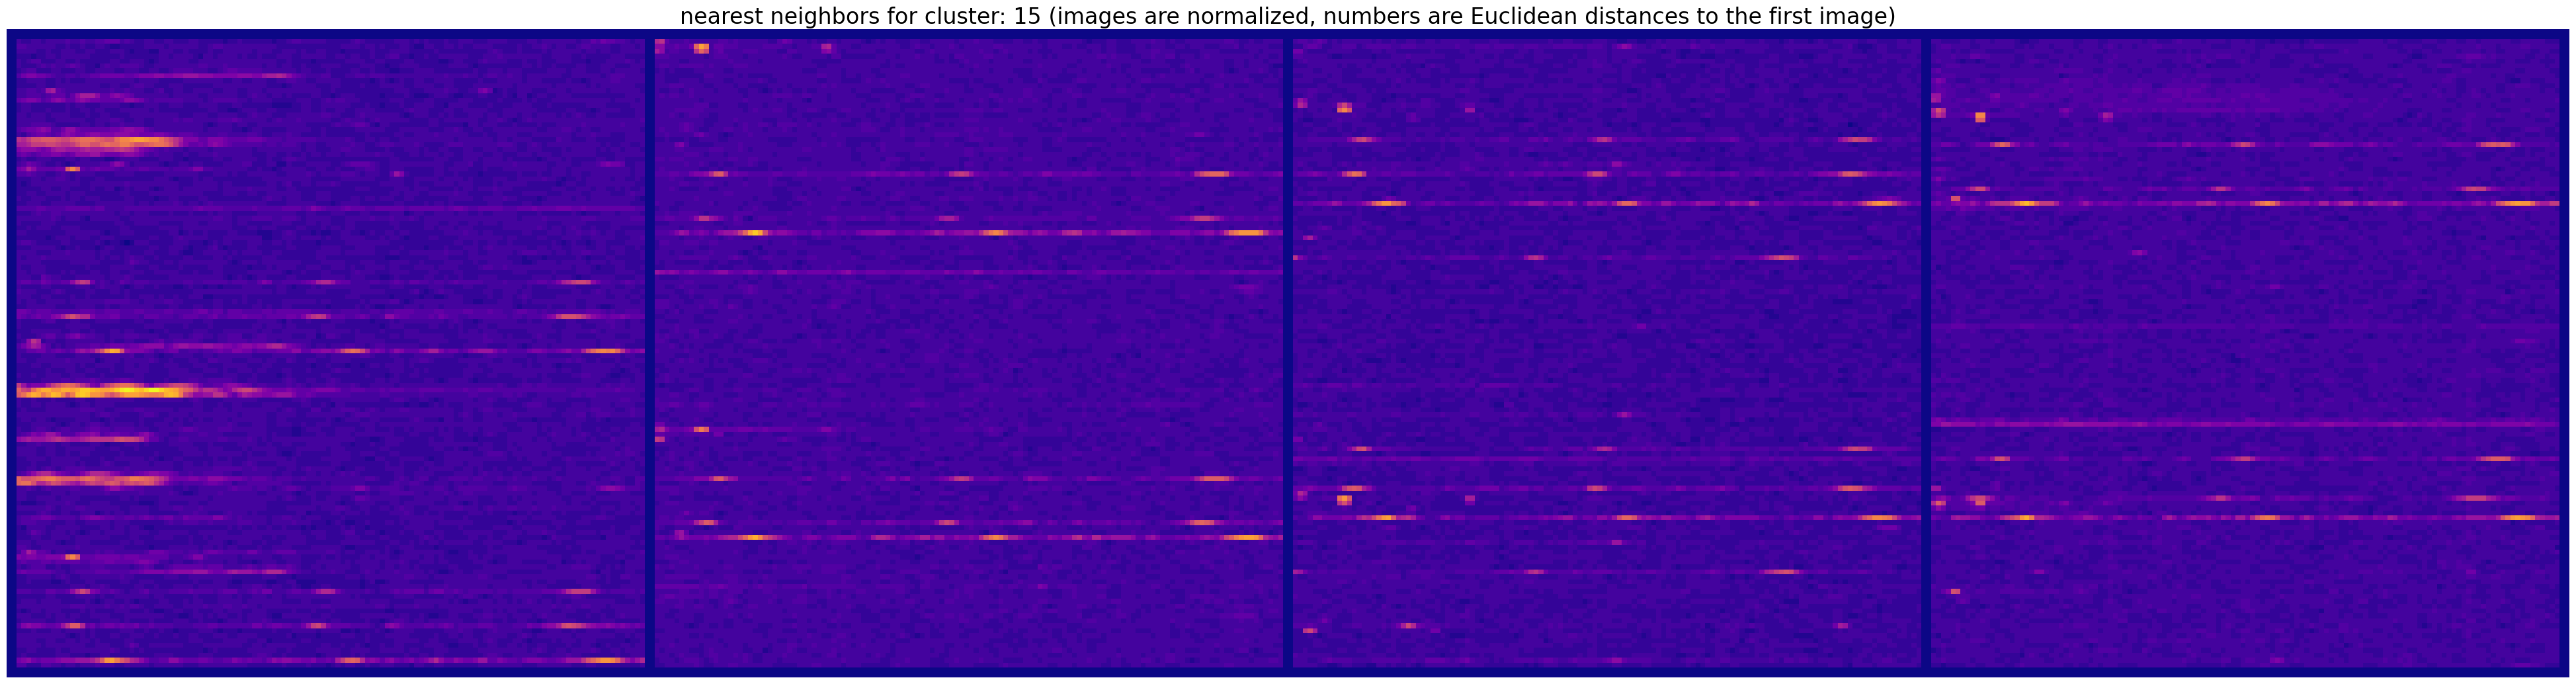

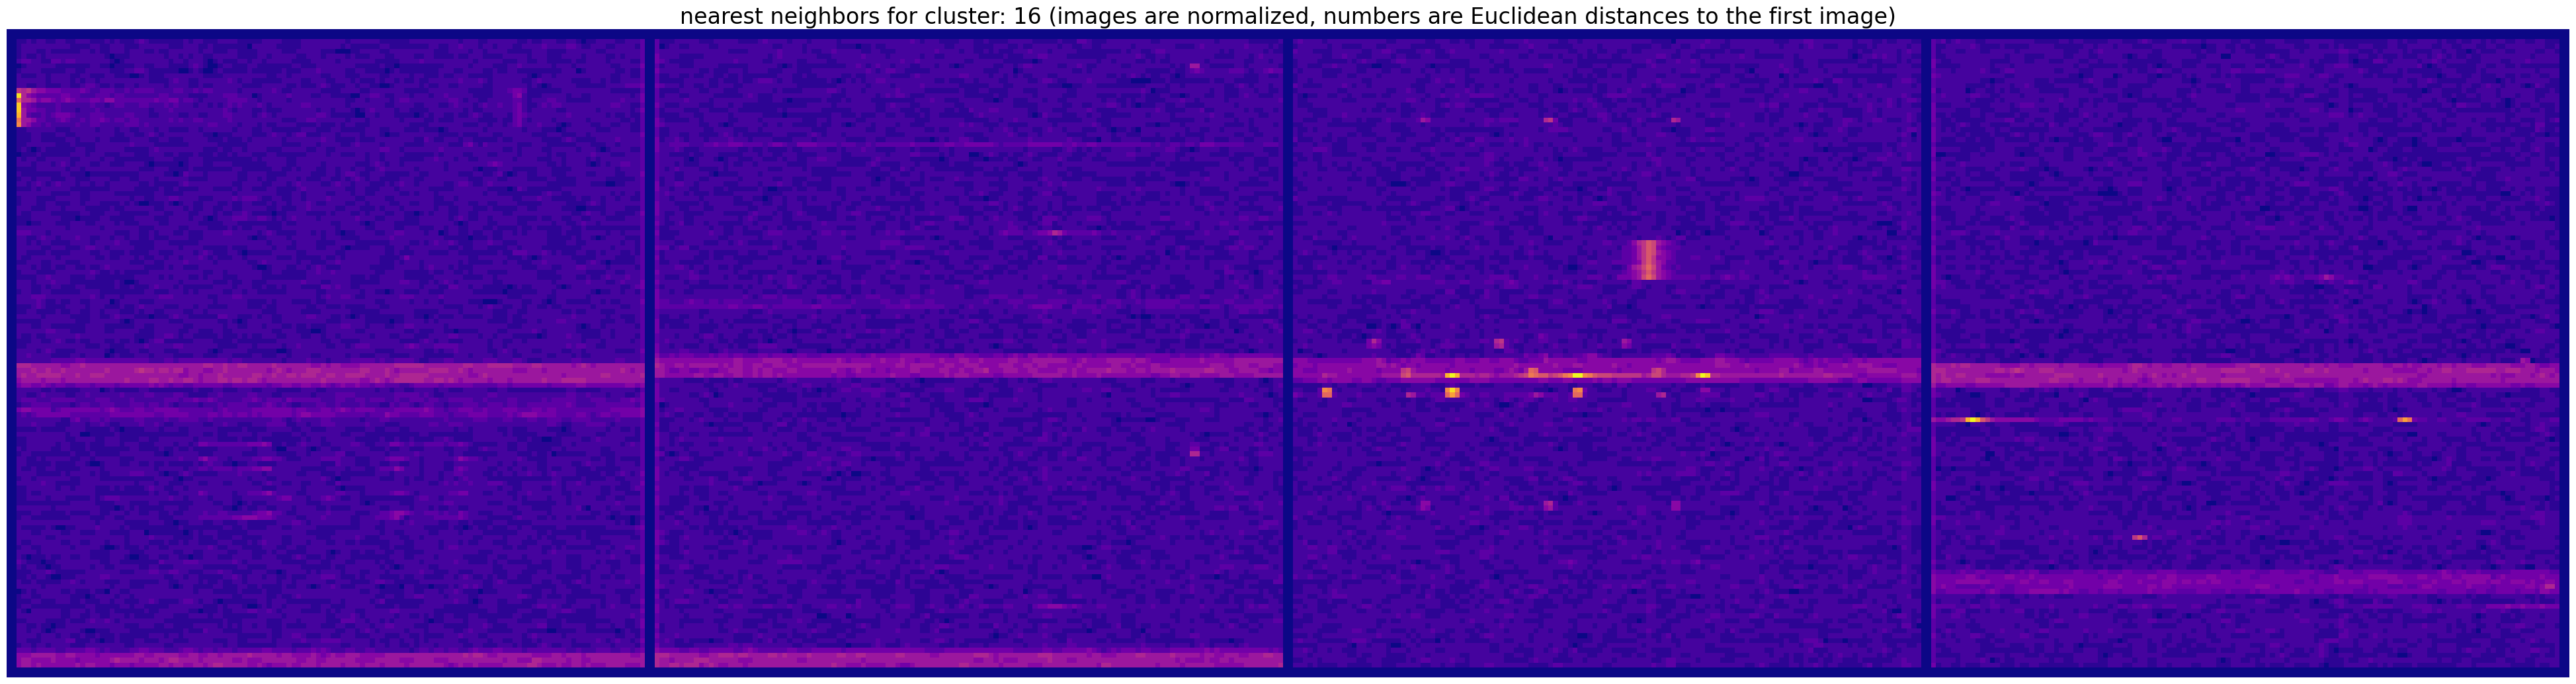

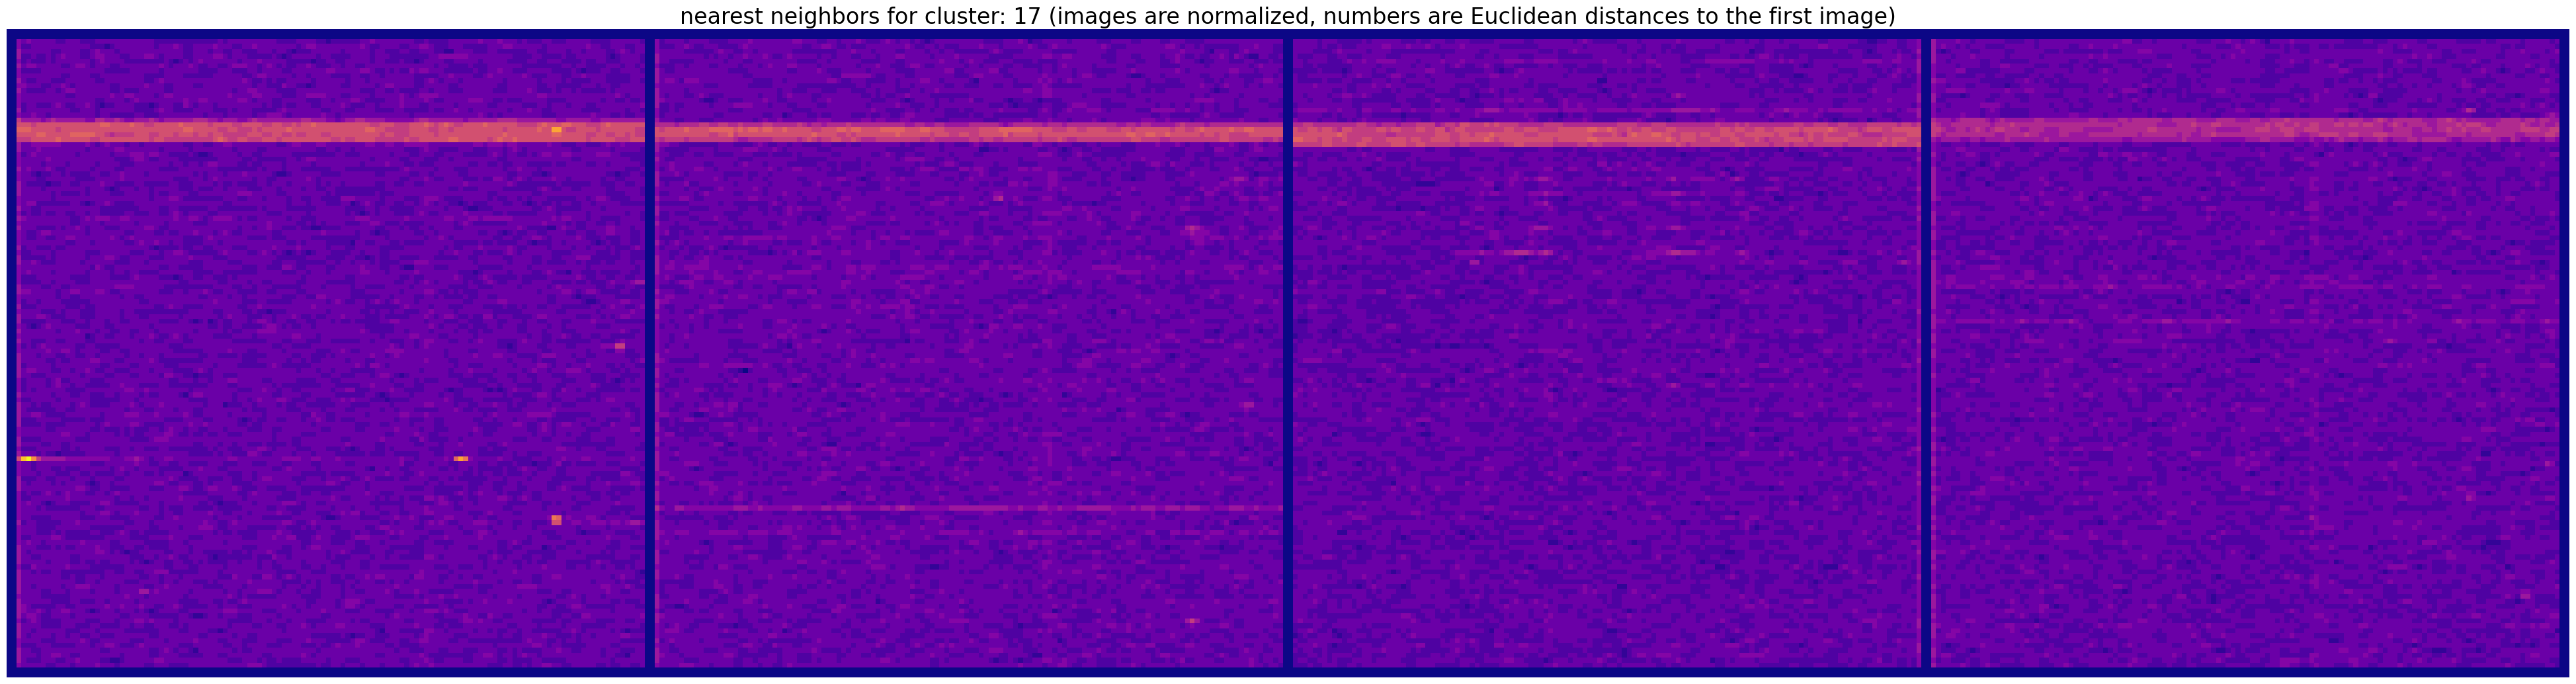

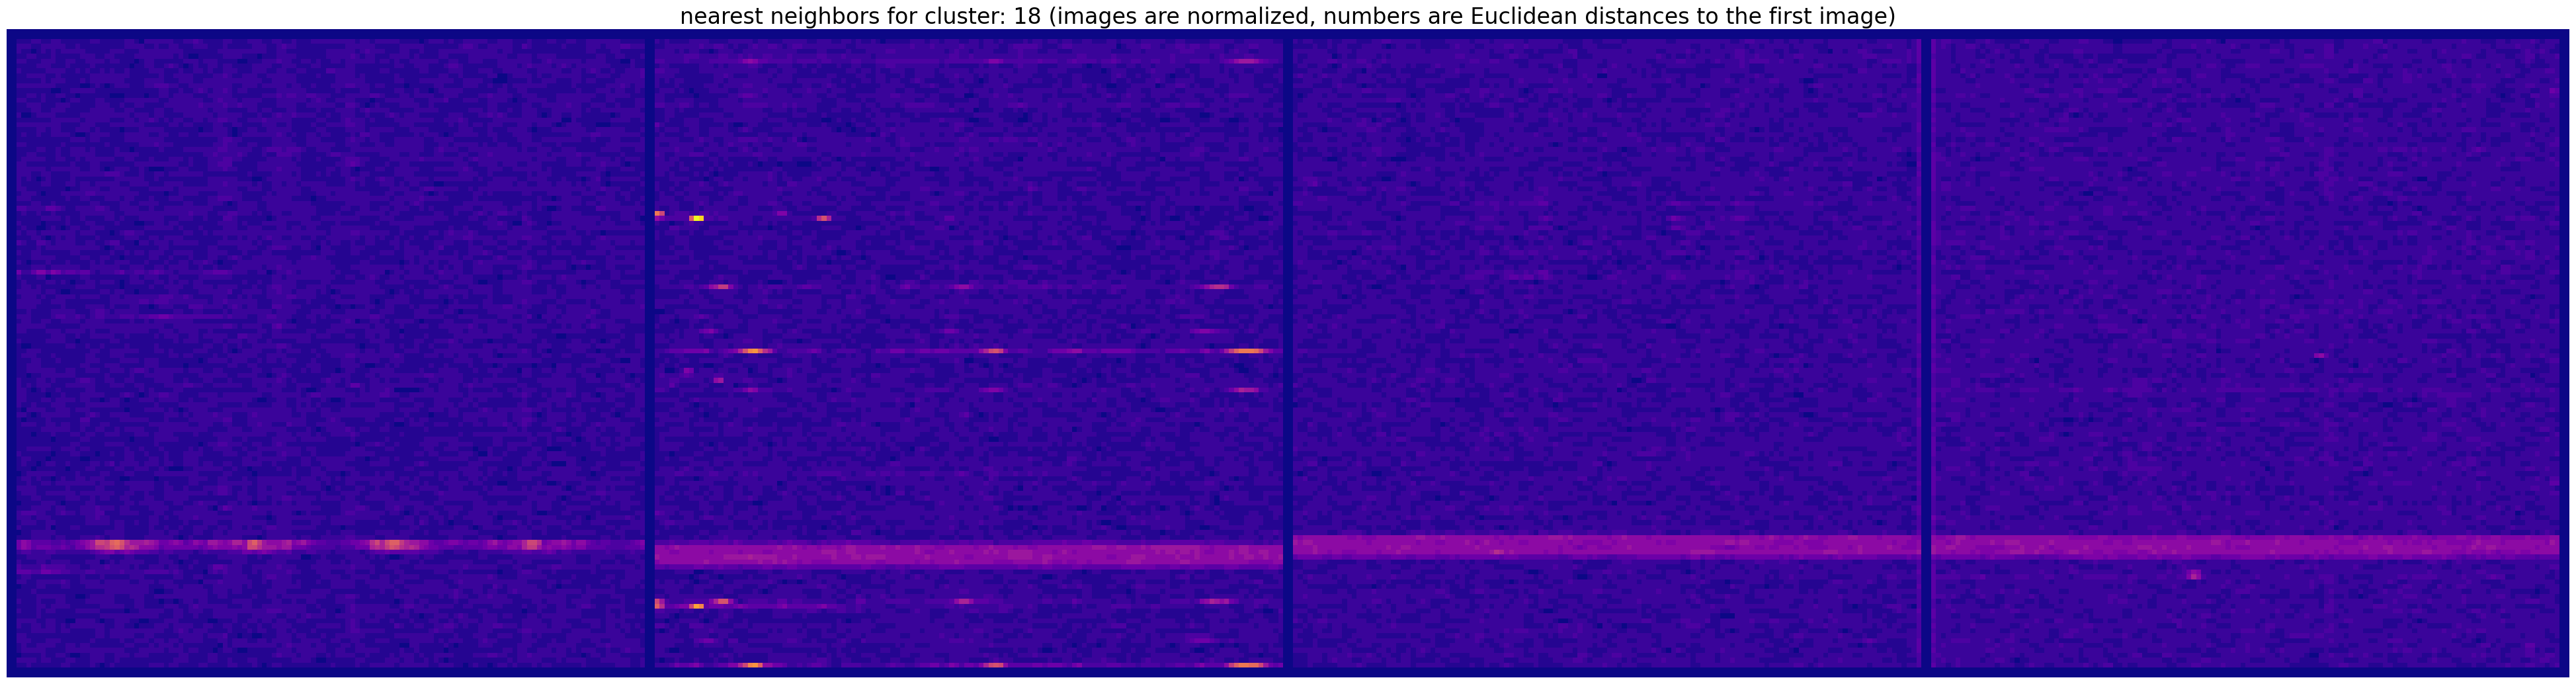

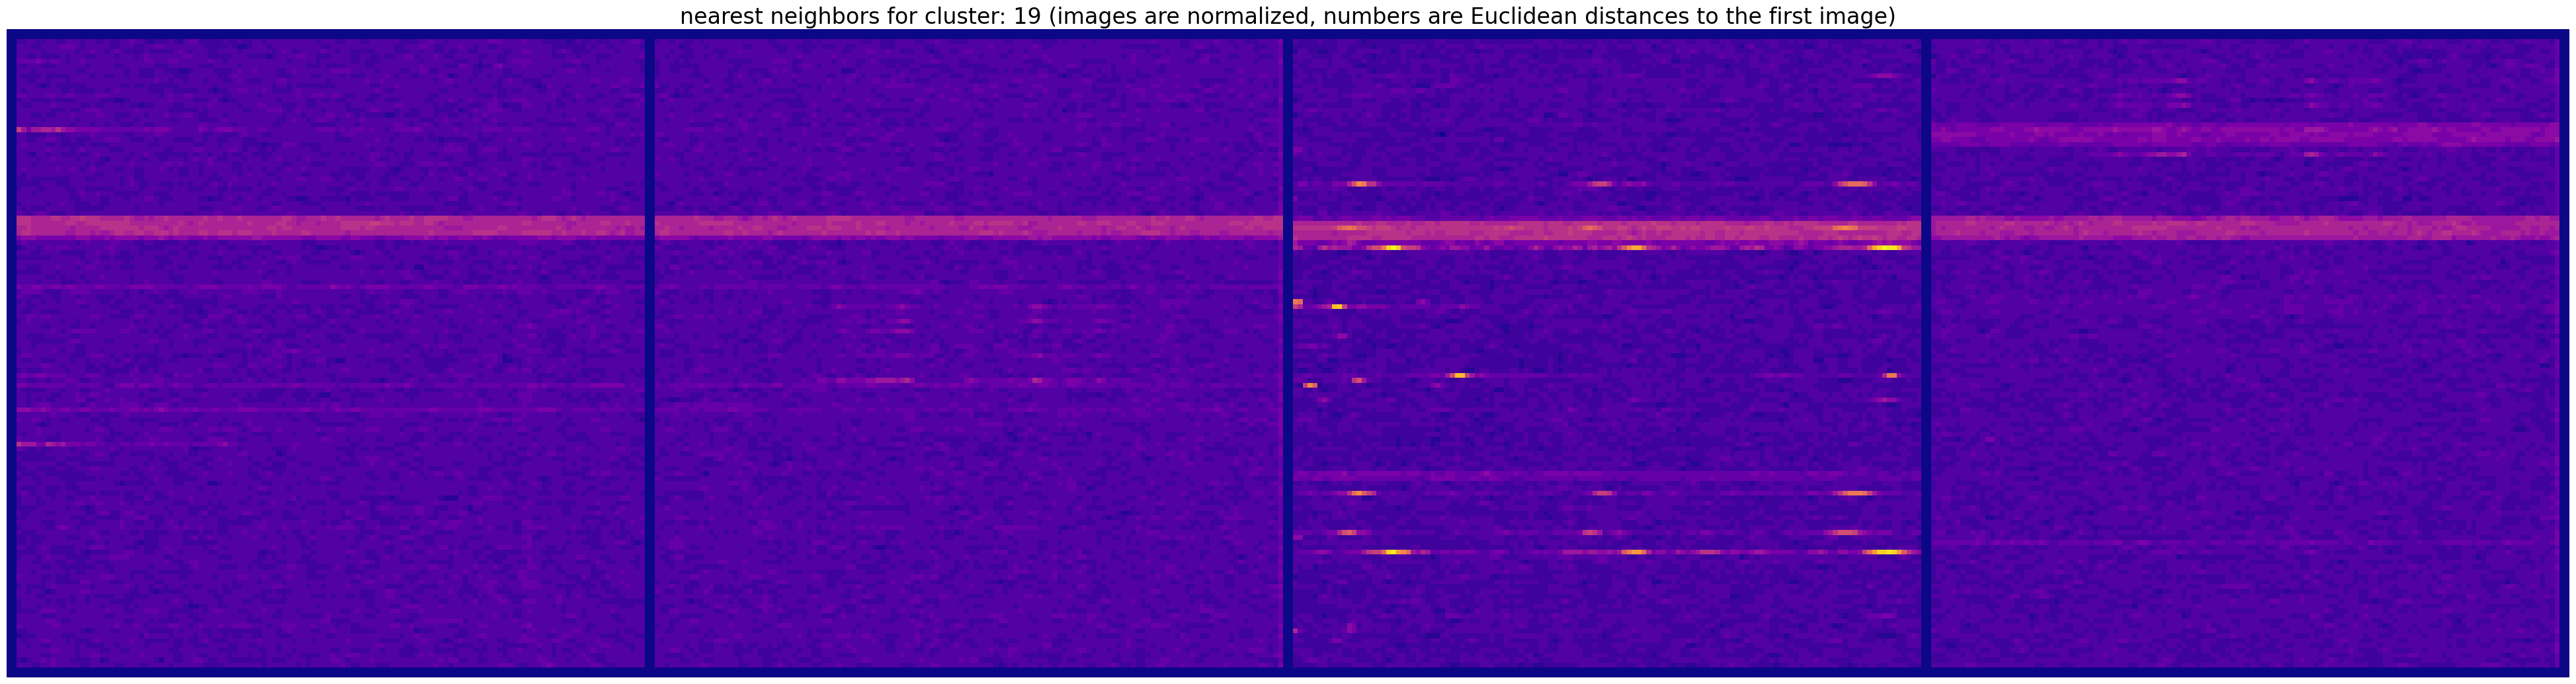

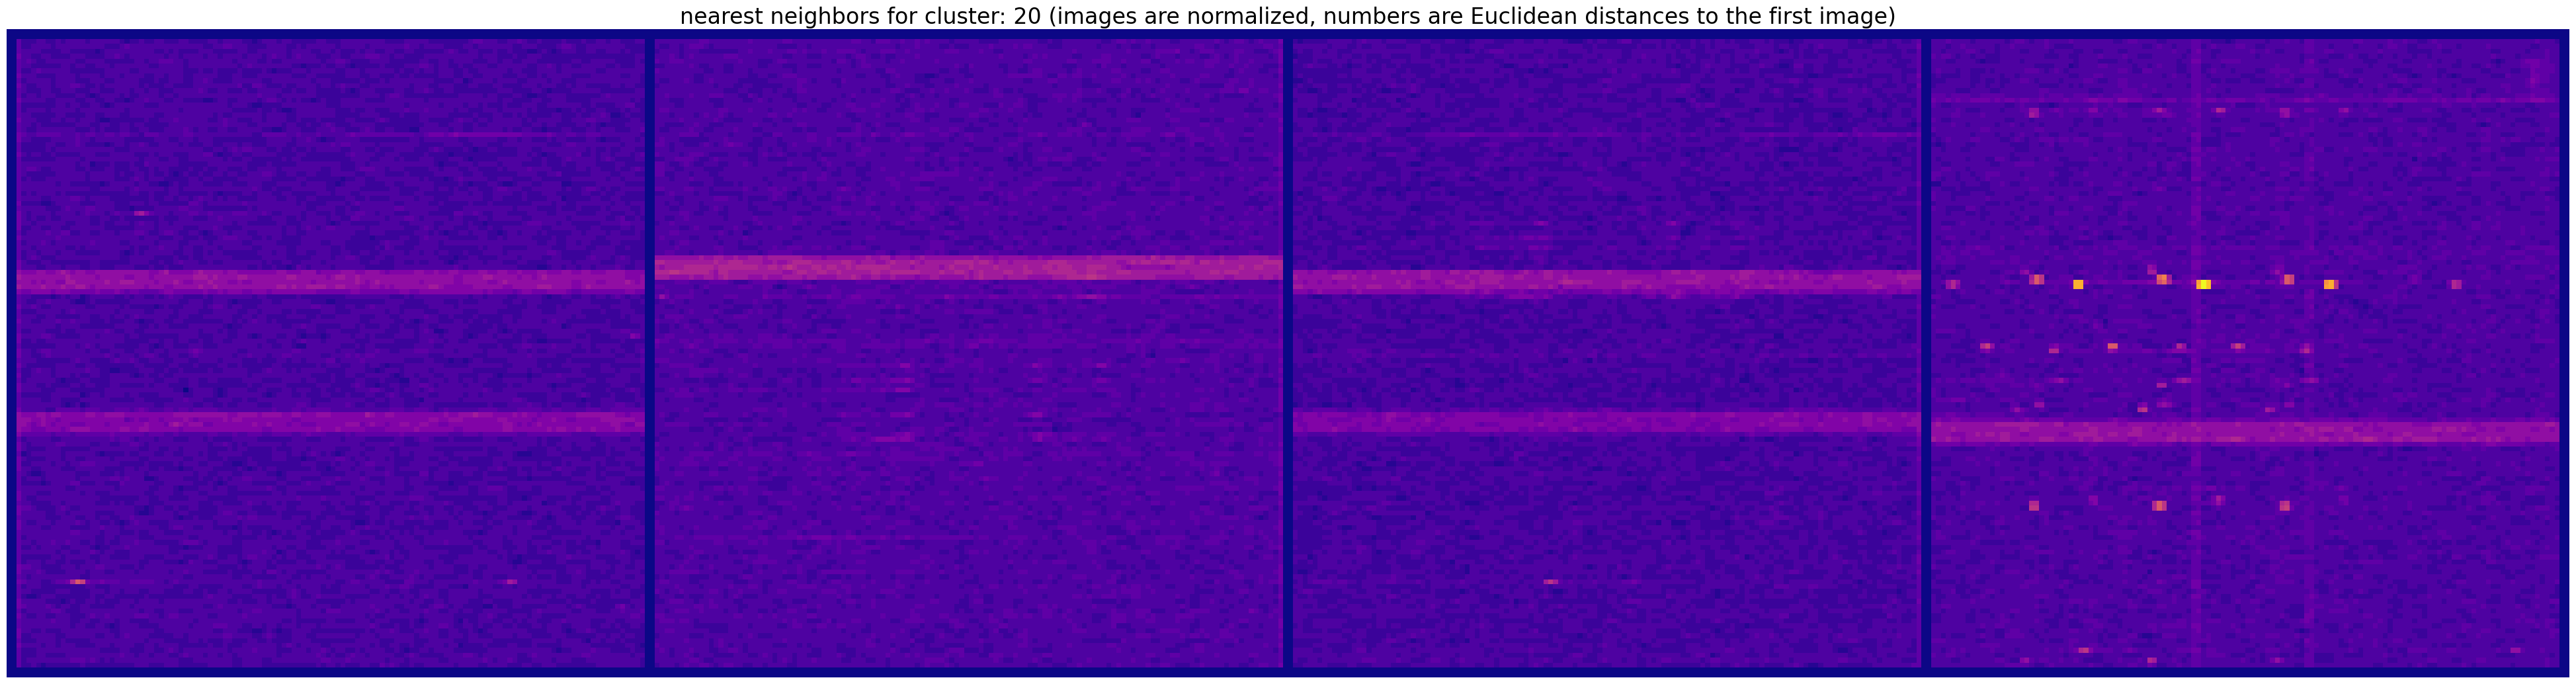

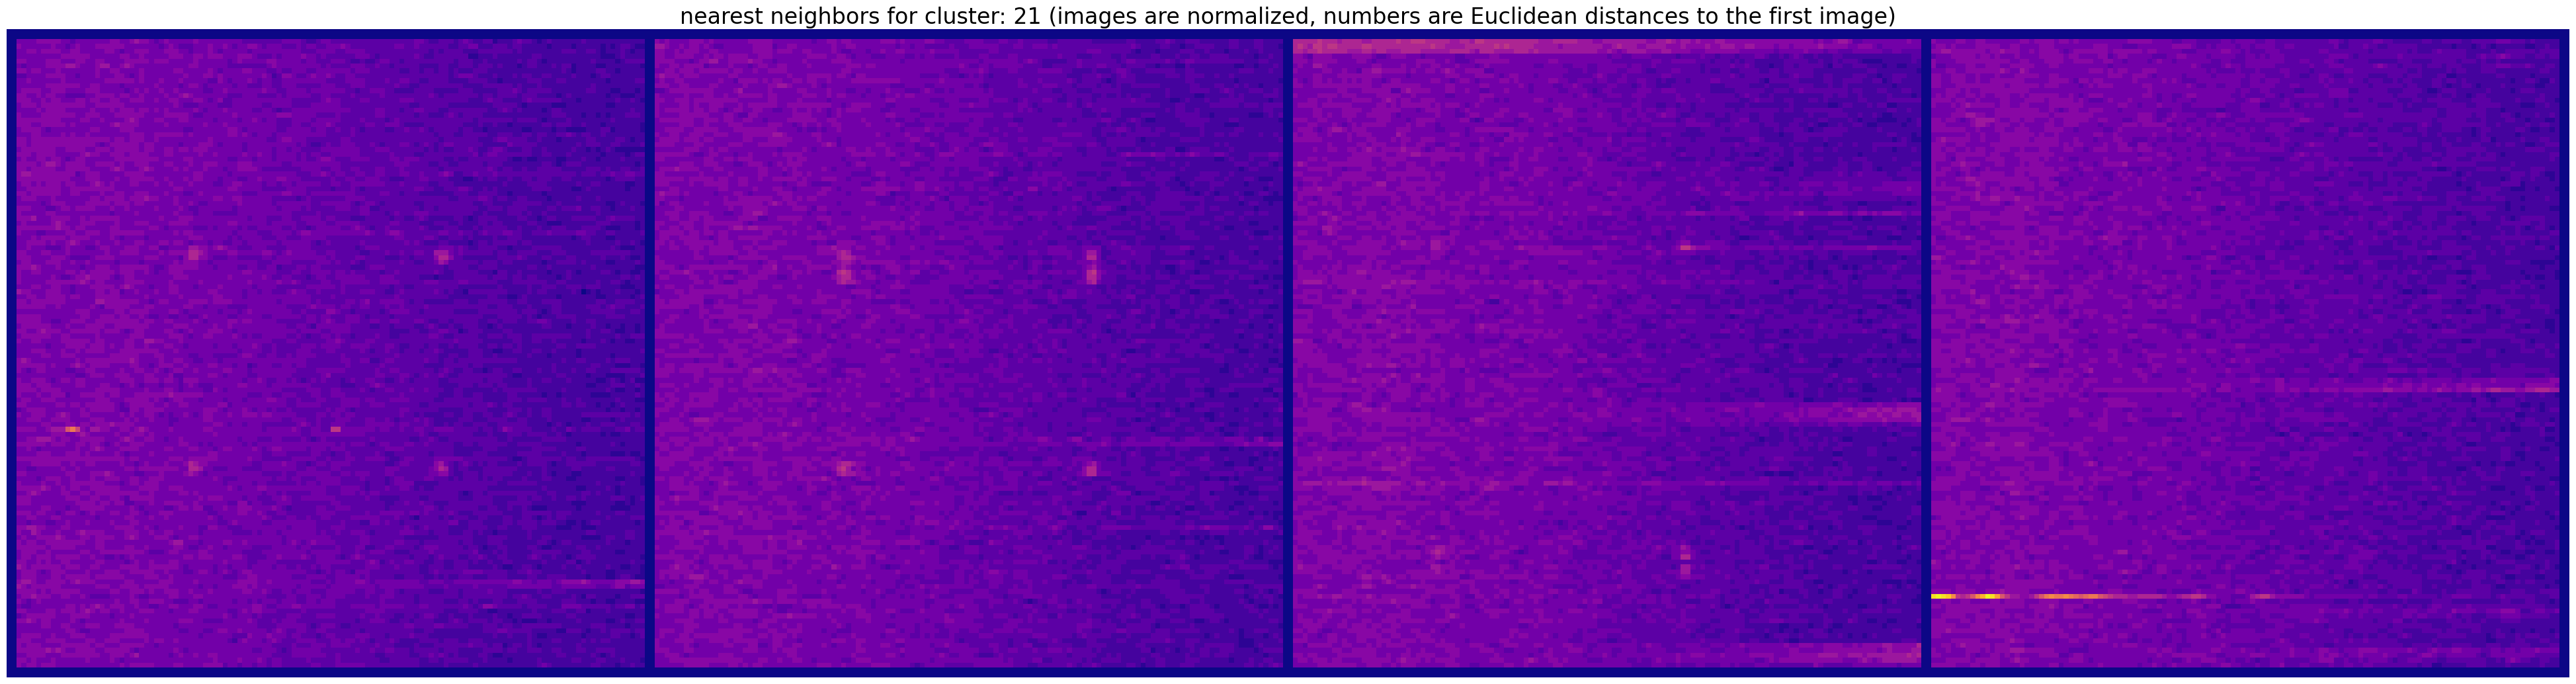

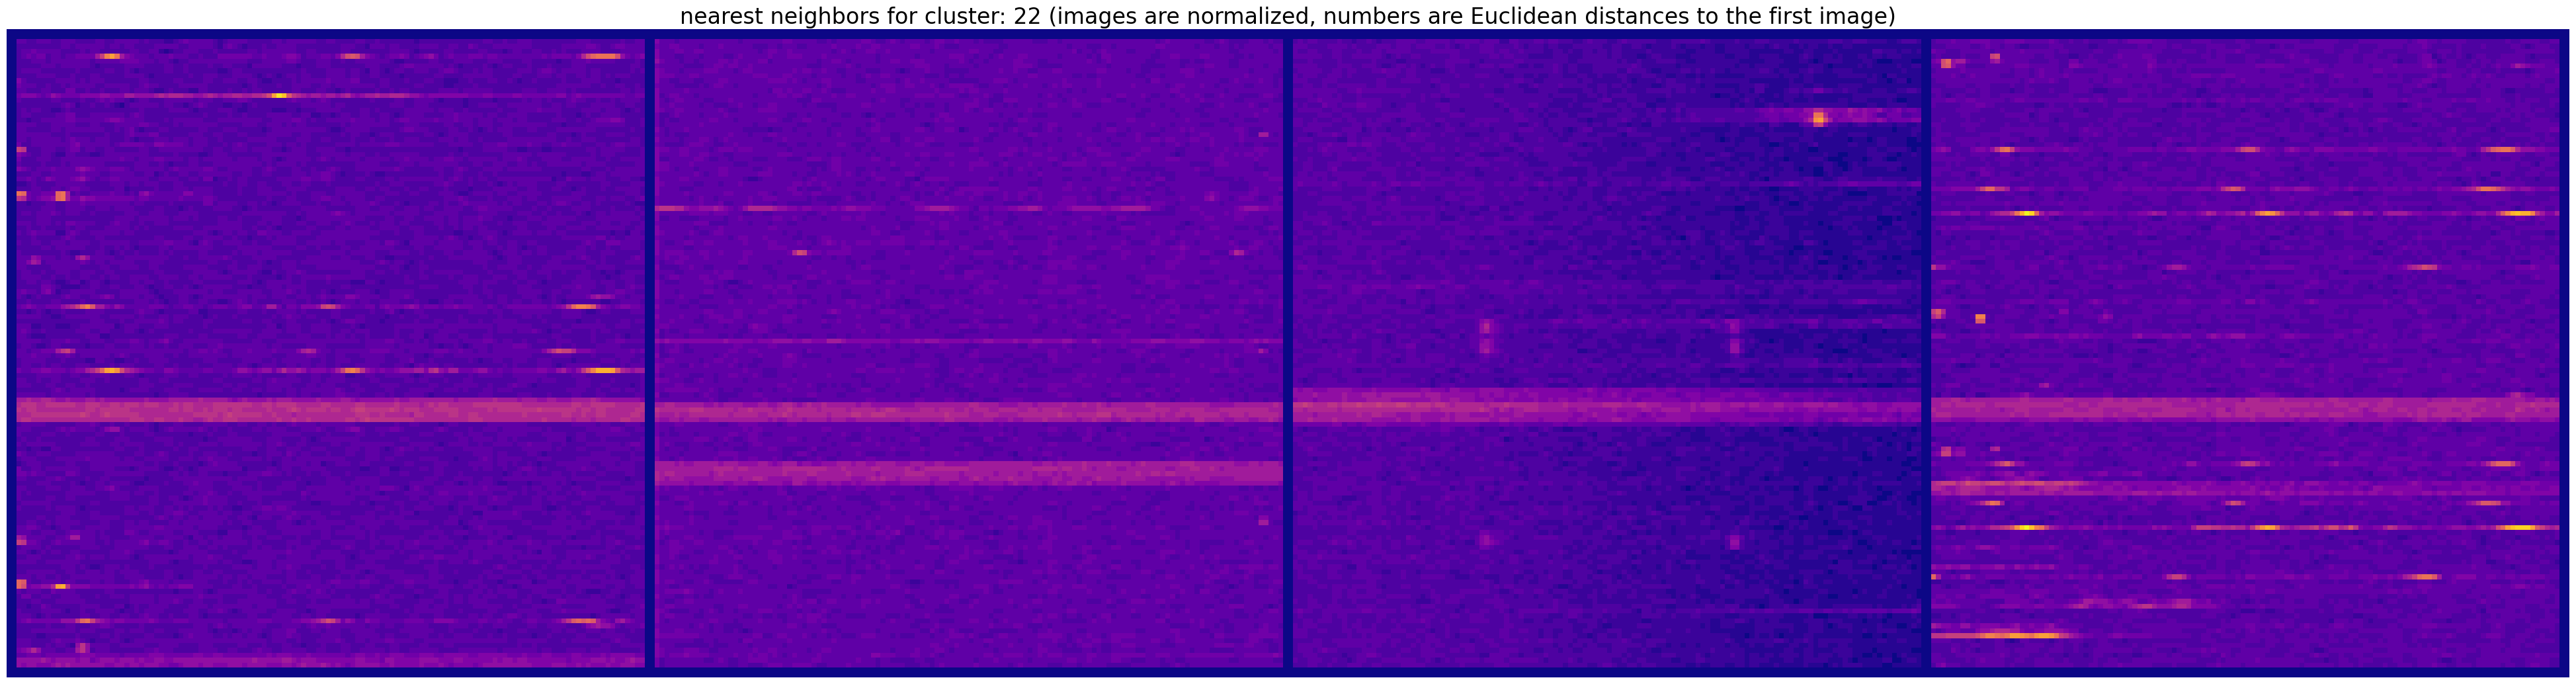

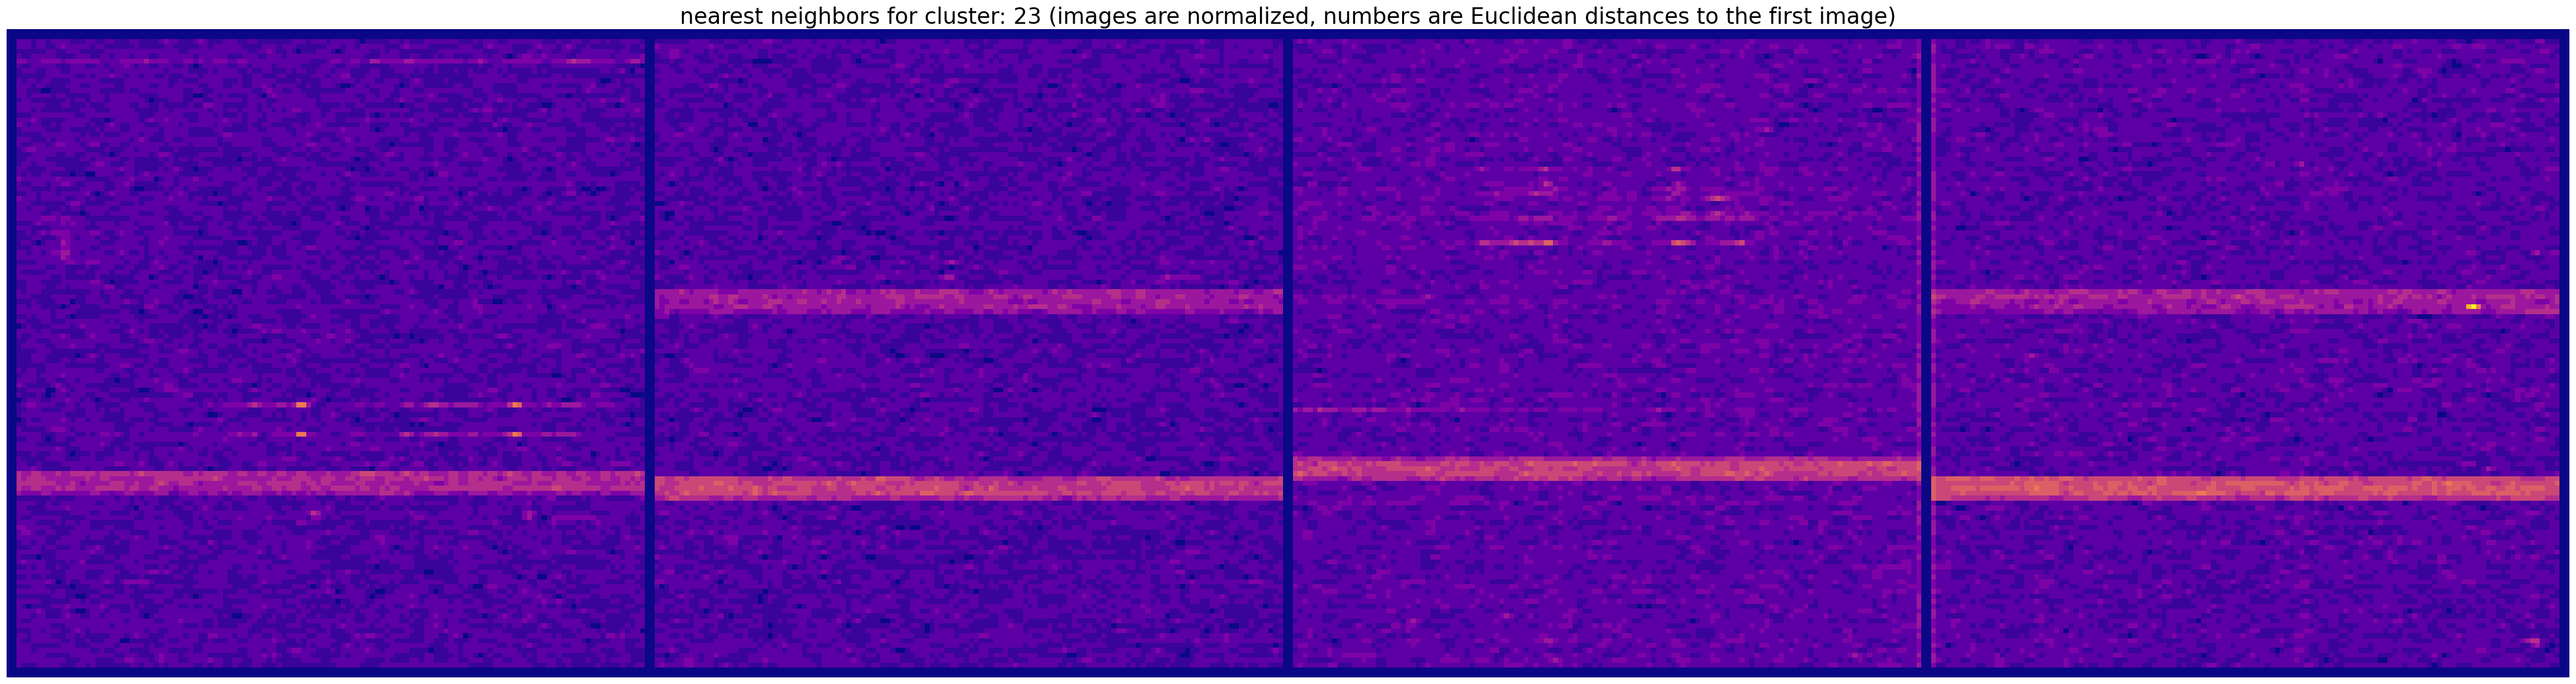

In [14]:
# Show and save first N-nearest neighbors for each cluster.
plt.rc('font', size=24)
# plt.figure(figsize=(10, 2))
knn = NearestNeighbors(metric='euclidean')
num_images = 4
# knn.fit(reduced)

pseudo_labels = np.array(pseudo_labels)

for i in range(cluster_centers.shape[0]):
    # Show nearest neighbors to the given cluster center.
    cluster_labels_indices = np.where(pseudo_labels==i)
    cluster_features = reduced[cluster_labels_indices]
    knn.fit(cluster_features)
    dist, neighbors = knn.kneighbors([cluster_centers[i]], n_neighbors=num_images,
                            return_distance=True)
    dist_list = []
    for j in range(len(dist[0])):
        dist_list.append(dist[0][j])

    utls.show_neighbors(dist_list, num_images, cluster_labels_indices[0][neighbors][0],
                 raw_dataset, i, normalize=True, cmap=CMAP)

    plt.savefig(RESULTS_PATH + "c" + str(i) + ".png", bbox_inches='tight', pad_inches = 0)

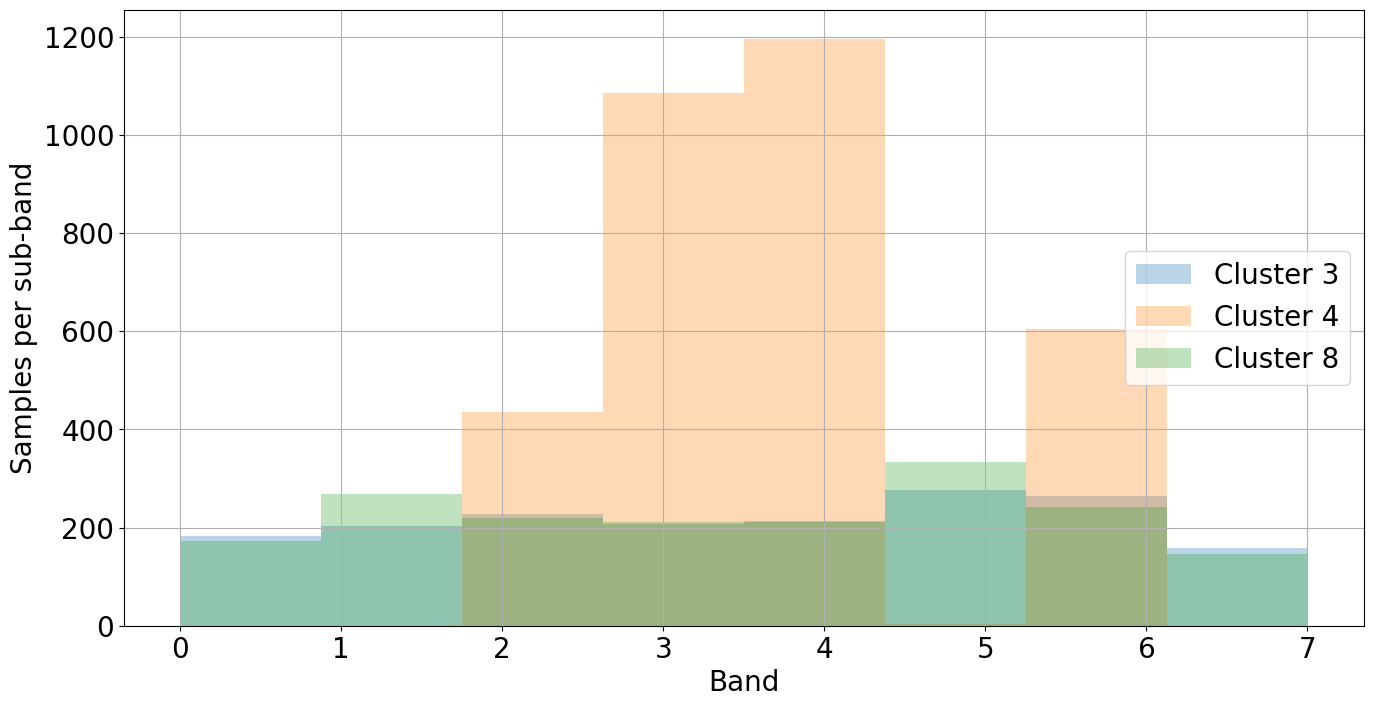

In [15]:
# Band occurence plot of selected clusters
fig = plt.figure(figsize=(16, 8))
plt.rc('font', size=20)
all_clus_data = []
# List of clusters to visualize
clus_to_show = [3, 4, 8]
for i in clus_to_show:
    single_clus_data = []
    for j in range(len(pseudo_labels)):
        if pseudo_labels[j] == i:
            single_clus_data.append(j%8)

    all_clus_data.append(single_clus_data)
    

for i in range(len(clus_to_show)):
    plt.hist(all_clus_data[i], bins=8, alpha=0.3, range=[0, 7], label='Cluster '+ str(clus_to_show[i]))
    # plt.title("Cluster " + str(i))
plt.ylabel("Samples per sub-band")
plt.xlabel("Band")
plt.legend(loc=7)
plt.grid()
plt.show()

extracting features: 100%|██████████| 313/313 [00:04<00:00, 71.13batch/s] 


Counter({4: 3324, 11: 2430, 21: 2377, 0: 2322, 15: 2203, 20: 2094, 8: 1803, 7: 1793, 16: 1758, 3: 1735, 22: 1631, 2: 1623, 14: 1598, 9: 1591, 18: 1582, 13: 1498, 1: 1465, 17: 1461, 6: 1450, 12: 1384, 23: 1373, 10: 1156, 19: 231, 5: 118})


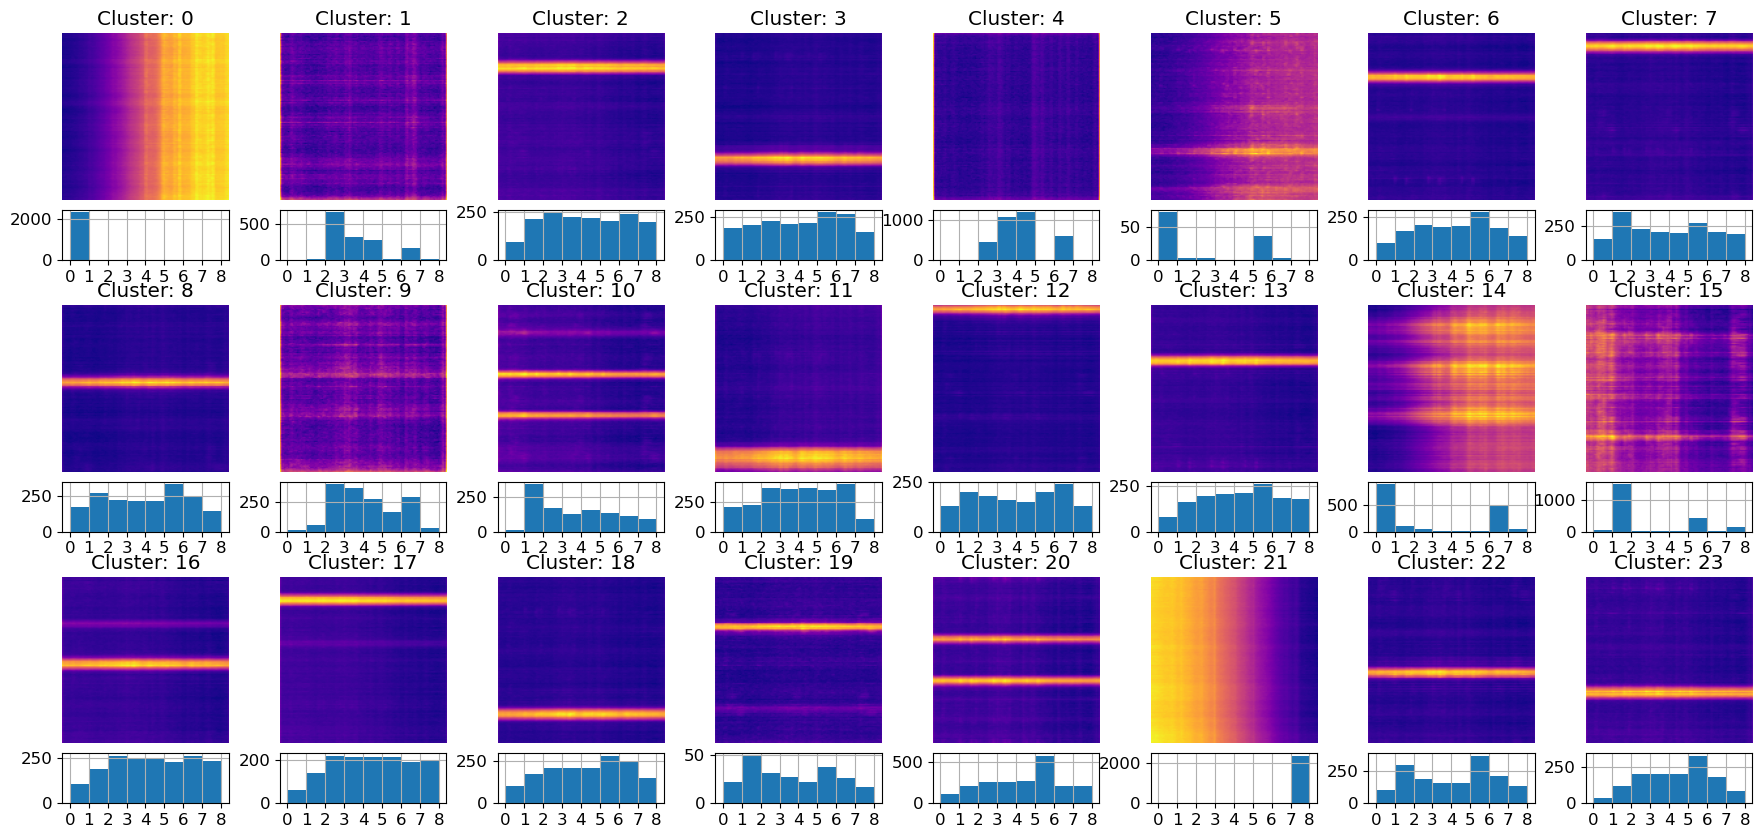

In [16]:
# Visualize average spectrogram and histogram per cluster
# Get labels with the loaded model
cnn_labels_array = utls.cnn_predict(raw_dataset, model, pin_memory, device)
counts = Counter(cnn_labels_array)
print(counts)

averaged_clusters = utls.get_averaged_clusters(counts, raw_dataset, cnn_labels_array)
utls.plot_avg_and_hist(counts, averaged_clusters, cnn_labels_array, rnd_list=None)

In [17]:
# Check if existing model is used in order to load the stat data.
if LOAD_SAVED_MODEL:
  with open(SAVED_STAT_PATH, 'r') as f:
    all_stats = json.load(f) 
else:
  all_stats = []

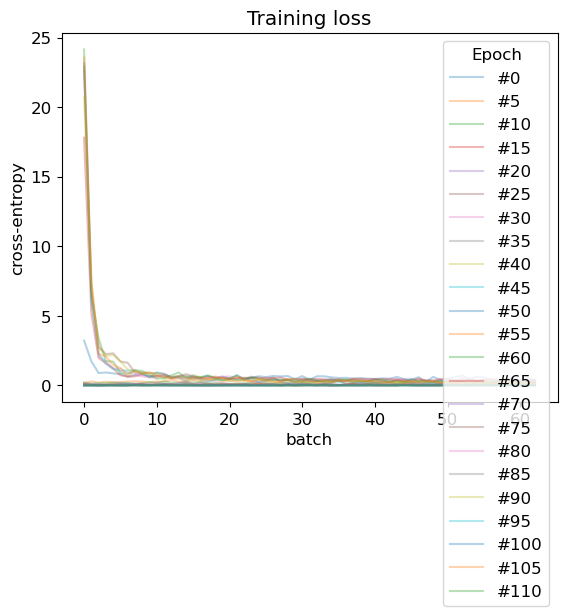

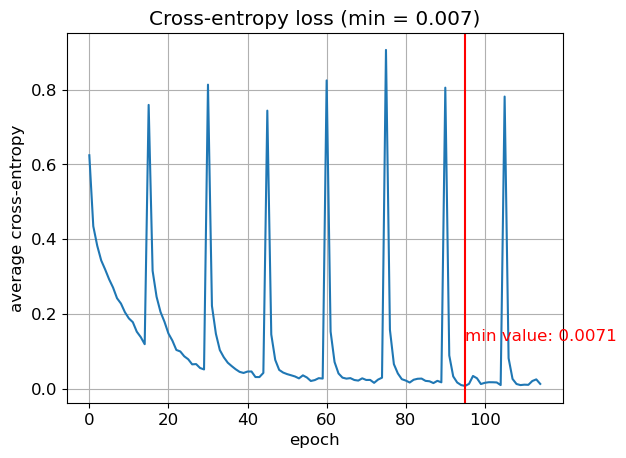

In [ ]:
# Plot training stats of the loaded model

plt.rc('font', size=12)
legend_step = 5
for idx, epoch in list(enumerate(all_stats))[::legend_step]:
  plt.plot(epoch['running_loss'][::legend_step], alpha=0.33, label=f'#{idx}')

plt.title('Training loss')
plt.xlabel('batch')
plt.ylabel('cross-entropy')
plt.legend(title='Epoch')
plt.savefig(RESULTS_PATH + "Loss c" + str(NUM_CLASSES) + ".png", 
            facecolor='w', bbox_inches='tight', pad_inches = 0)
plt.show()


_loss = [epoch['loss'] for epoch in all_stats]
plt.plot(_loss)
opt_value = _loss.index(min(_loss))
plt.axvline(x=opt_value, color='r')
plt.annotate("min value: " + str(round(min(_loss), 4)),
                     (opt_value, sum(_loss)/len(_loss)), color='r')
plt.title(f'Cross-entropy loss (min = {min(_loss):.3f})')
plt.xlabel('epoch')
plt.ylabel('average cross-entropy')
plt.savefig(RESULTS_PATH + "Mean cross_entropy c" + str(NUM_CLASSES) + ".png", 
            facecolor='w', bbox_inches='tight', pad_inches = 0)
plt.grid()
plt.show()

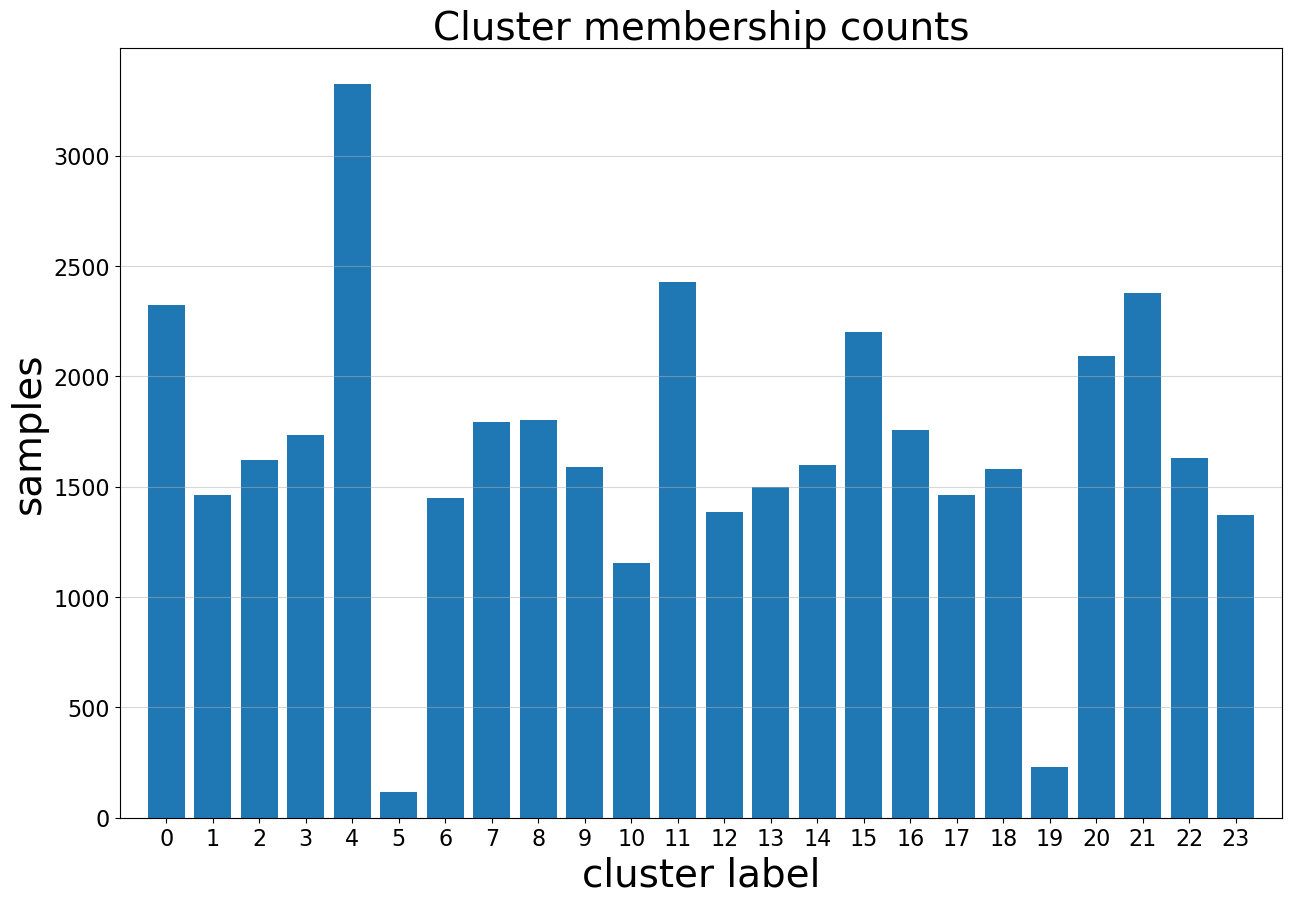

In [ ]:
# Show cluster counts

items = list(counts.items())
sorted_counts = sorted(counts)
list_counts = []
for i in sorted_counts:
    list_counts.append(counts[i])

fig = plt.figure(figsize=(15, 10))
plt.rc('font', size=16)

plt.title('Cluster membership counts', fontsize=28)
plt.xlabel('cluster label', fontsize=28)
plt.ylabel('samples', fontsize=28)

x_ticks = np.arange(0, 24, 1)

plt.xticks(x_ticks)
plt.grid(which='major', axis='y', alpha=0.5)
plt.bar(sorted_counts, list_counts)
plt.xlim(-1, KMEANS_CLUSTERS)
plt.savefig(RESULTS_PATH + "Cluster counts c" + str(NUM_CLASSES) + ".png",
            facecolor='w', bbox_inches='tight', pad_inches = 0)
plt.show()

/home/jovyan/working folder/code/SSLUtils.py:137: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(25, 5))


+---------+------------------+-------------------------+-------------------------+-----------------------+
| Cluster | Number of images | Minimum sample distance | Maximum sample distance | Mean samples distance |
+---------+------------------+-------------------------+-------------------------+-----------------------+
|    4    |       3324       |        0.2091424        |        1.0627499        |       0.4562285       |
|    11   |       2430       |        0.2731069        |        0.9722918        |       0.6189068       |
|    21   |       2377       |        0.2425446        |        1.0407475        |       0.5251264       |
|    0    |       2322       |        0.2926532        |        0.9445837        |       0.6032867       |
|    15   |       2203       |        0.3716879        |        0.9973340        |       0.7000452       |
|    20   |       2094       |        0.2946248        |        1.0139536        |       0.5819930       |
|    8    |       1803       |       

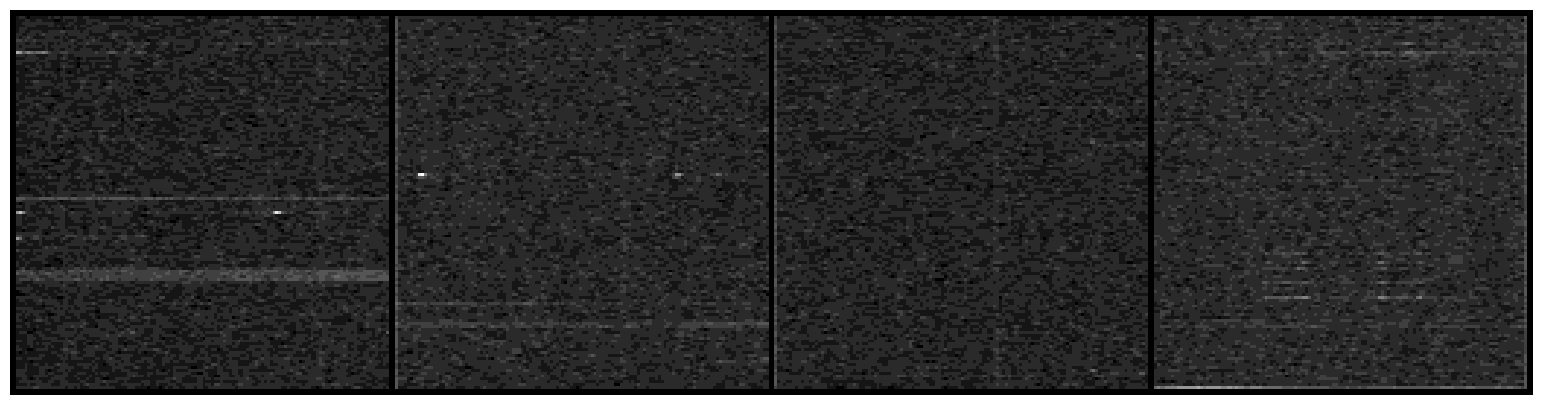

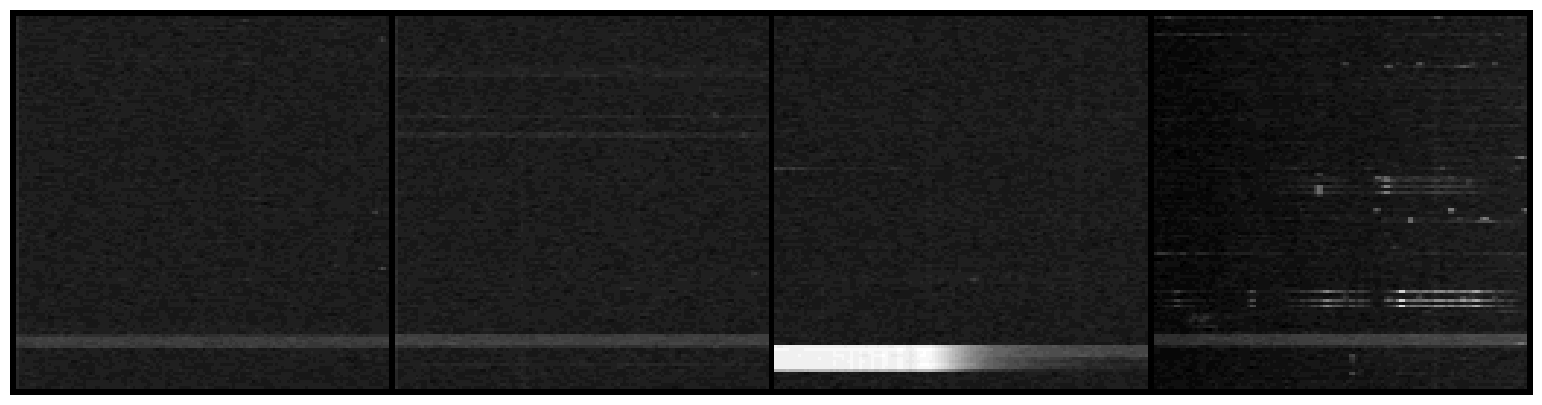

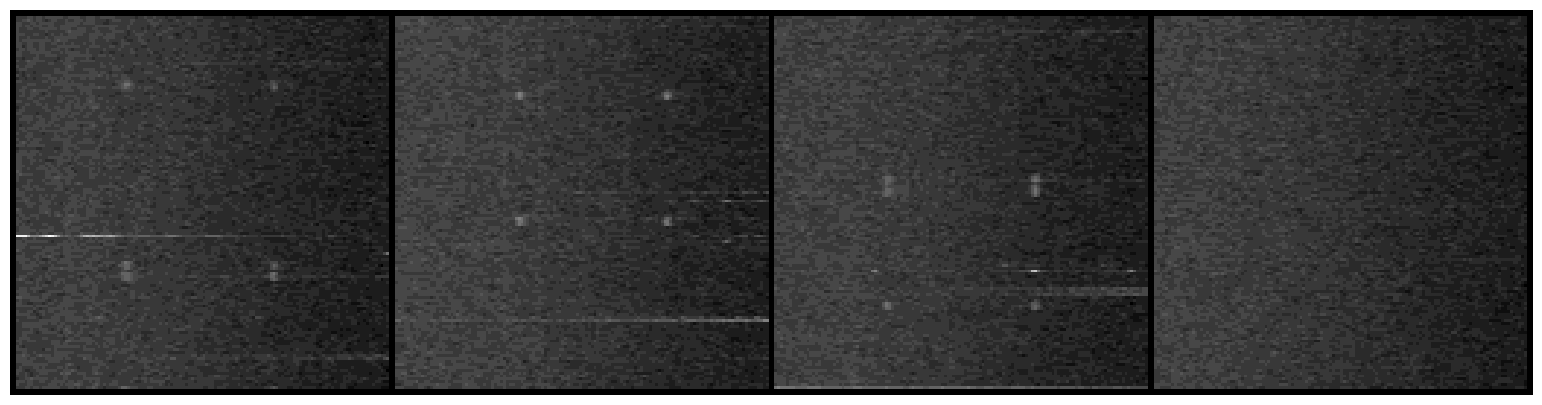

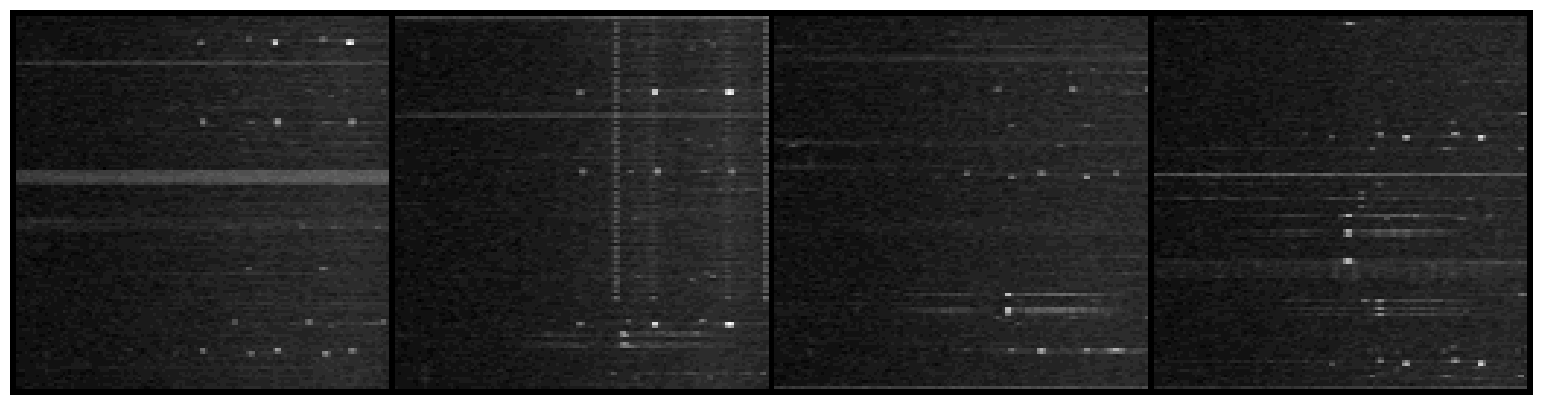

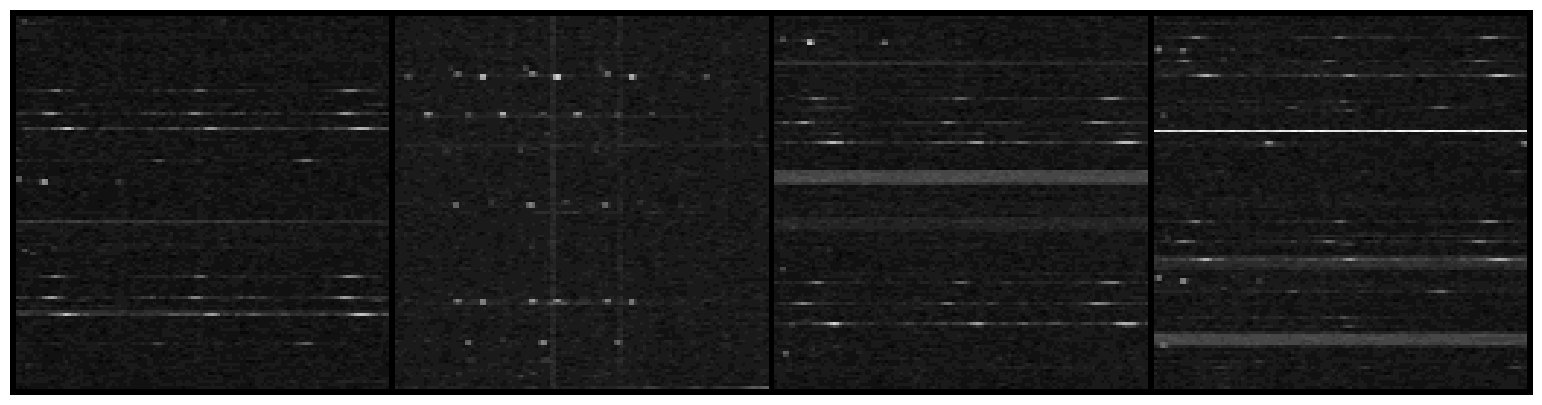

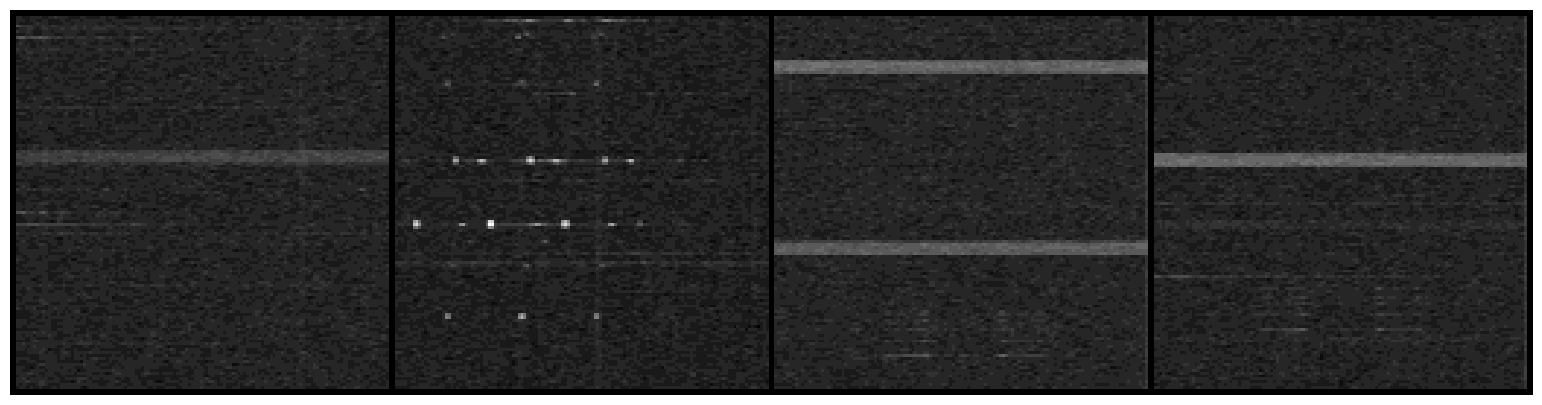

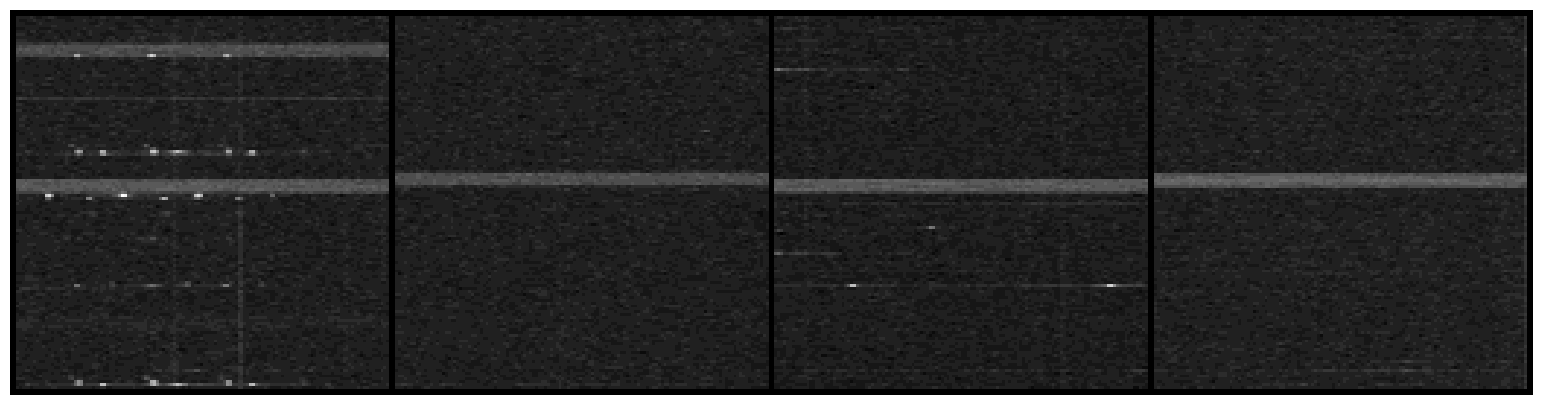

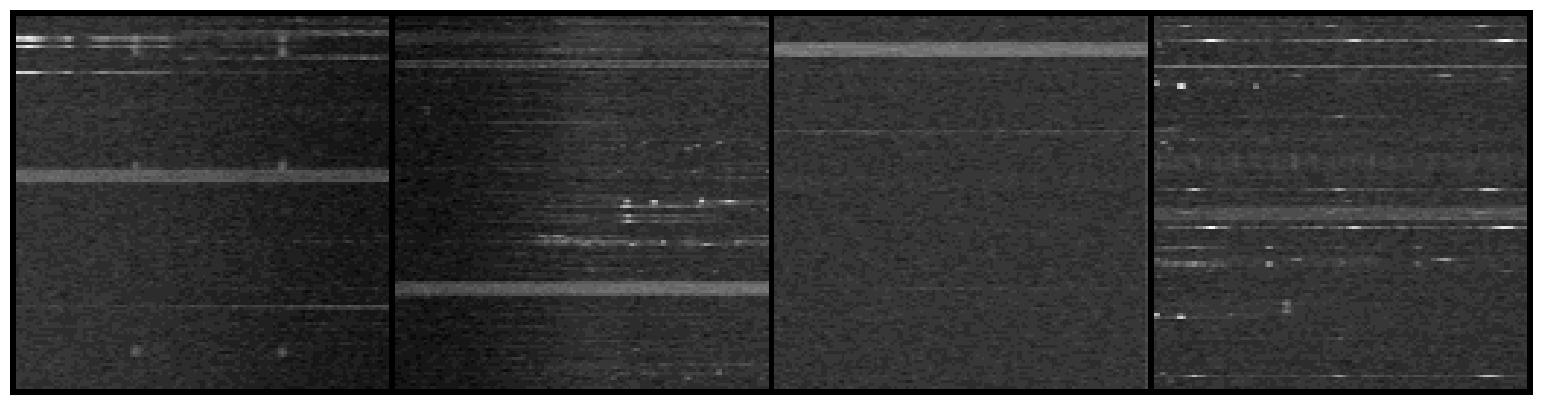

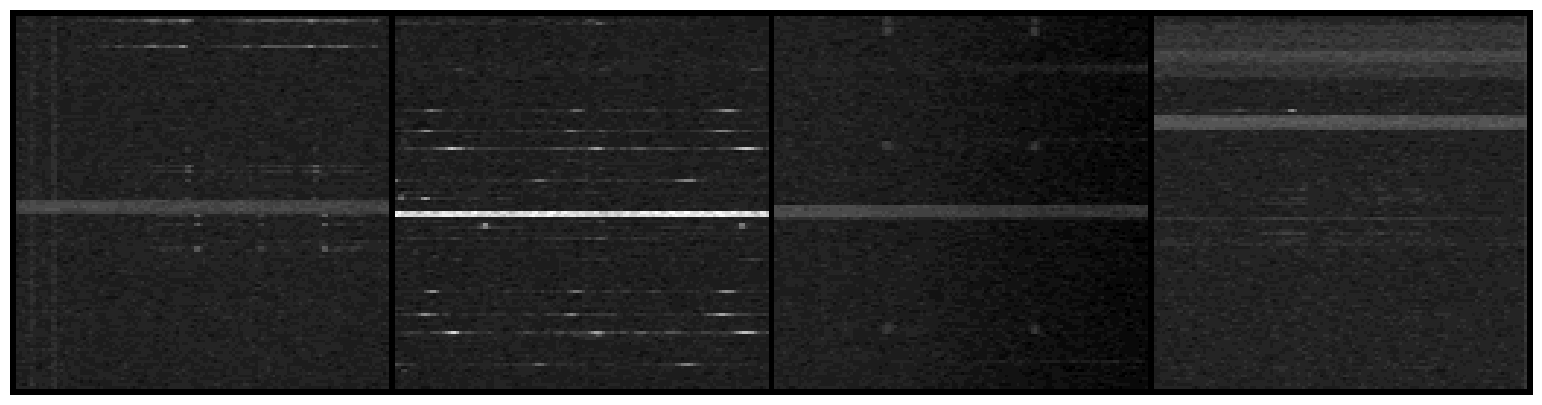

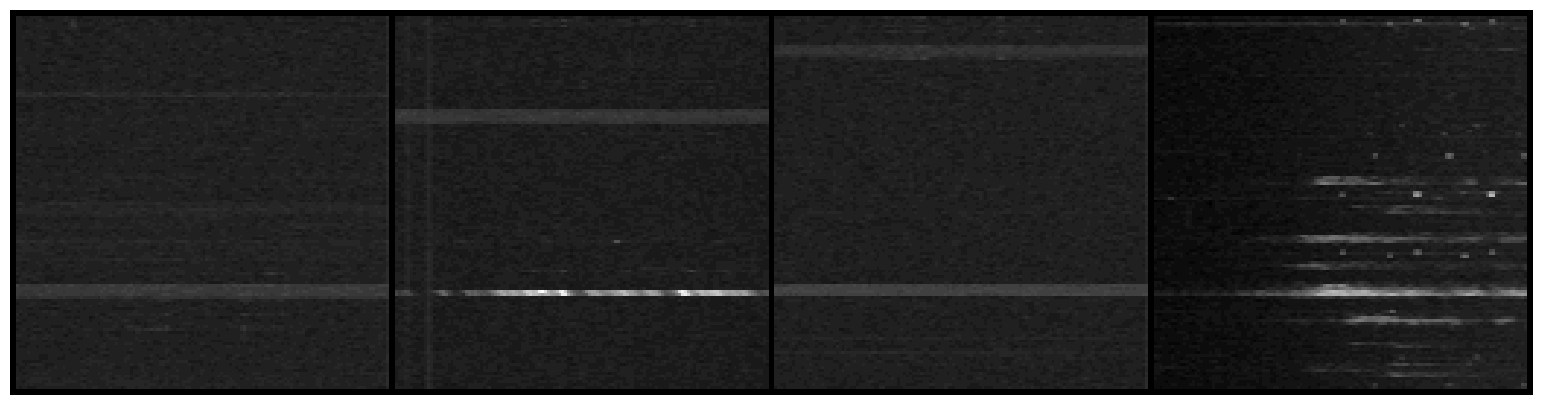

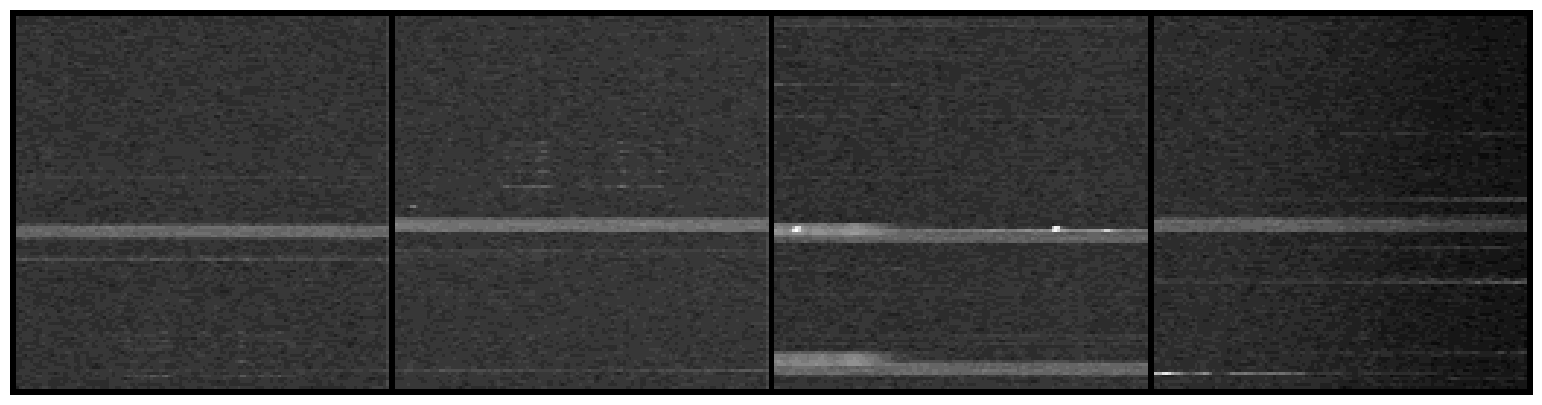

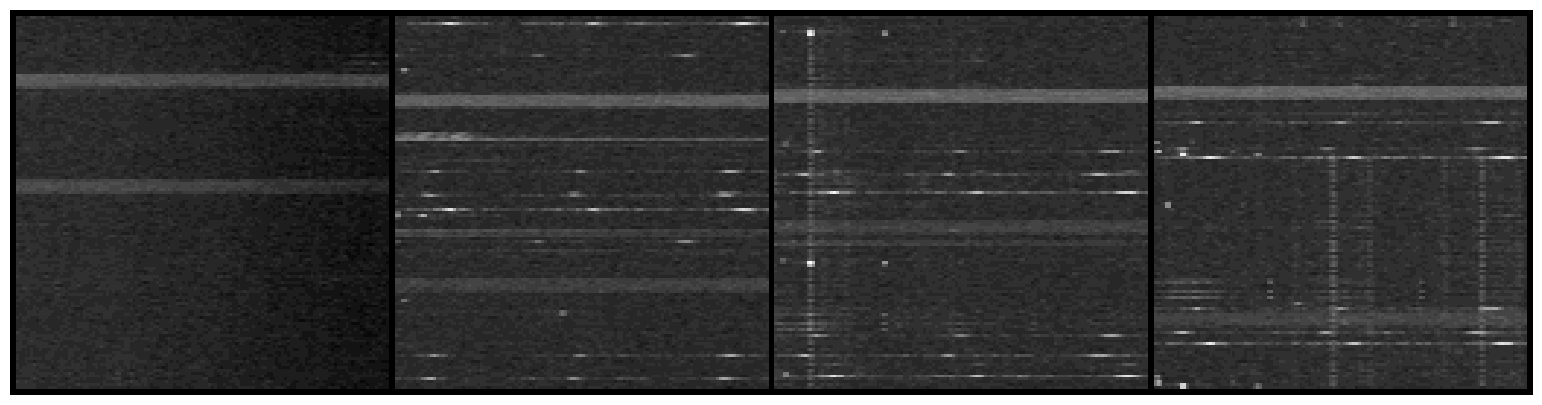

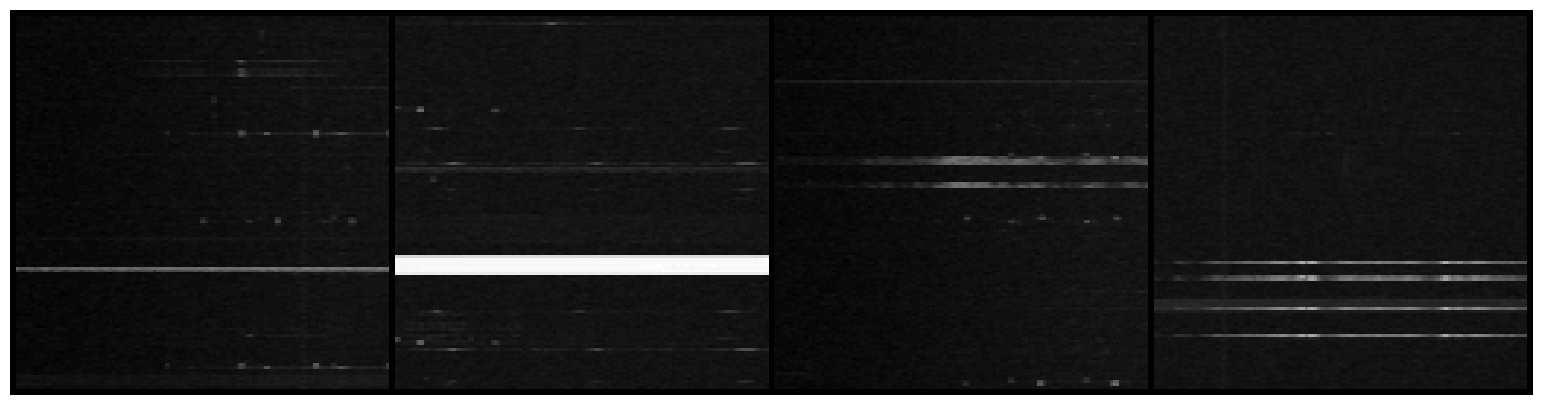

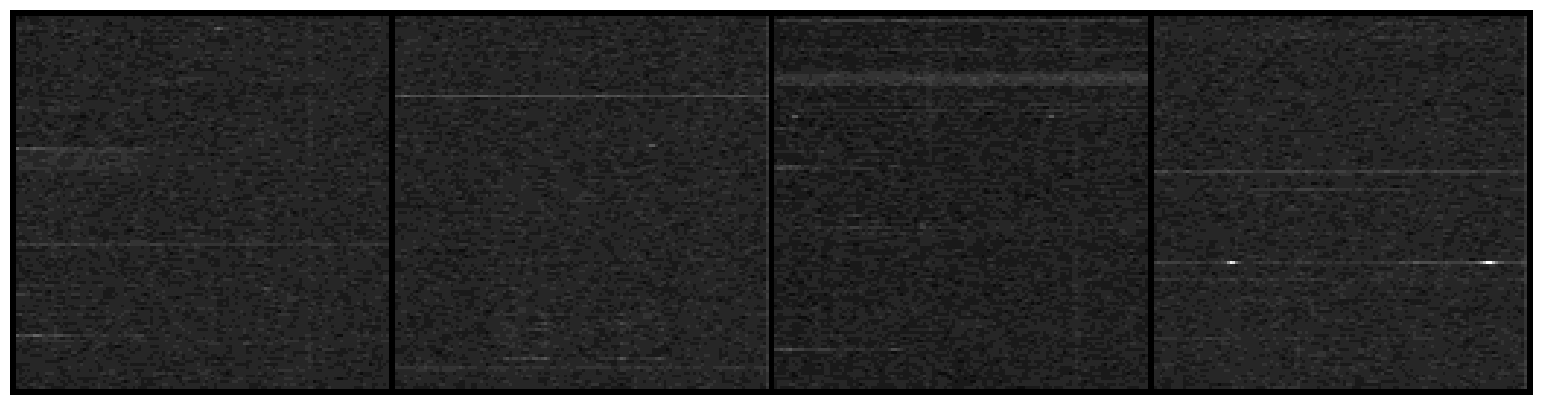

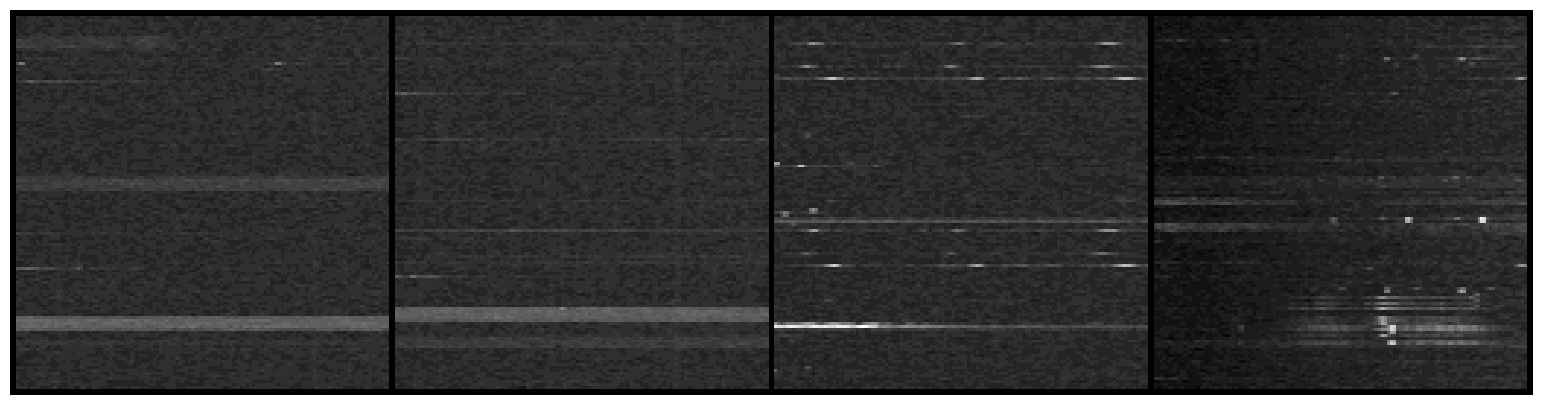

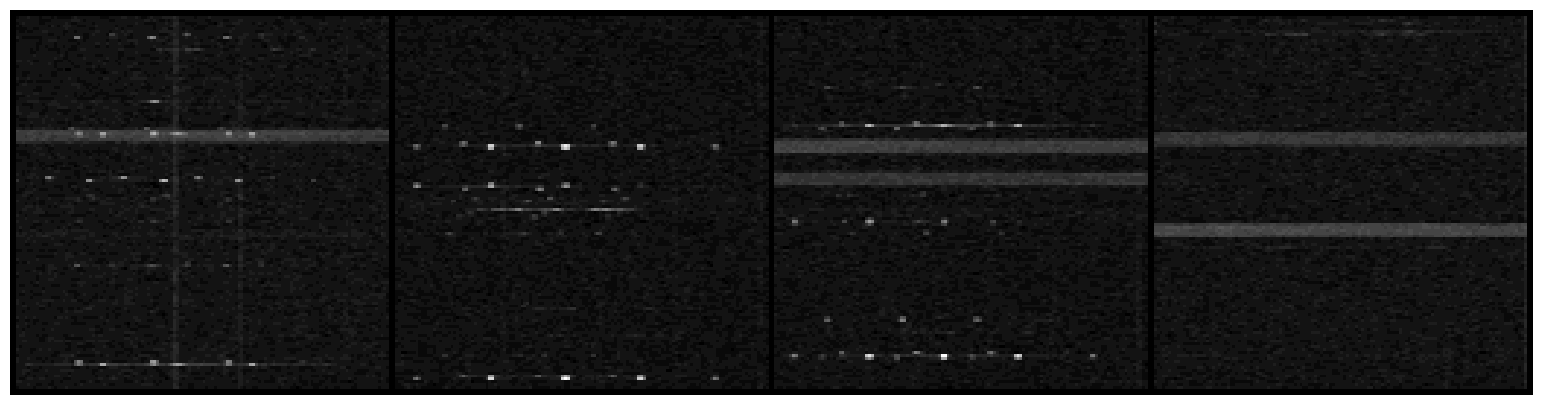

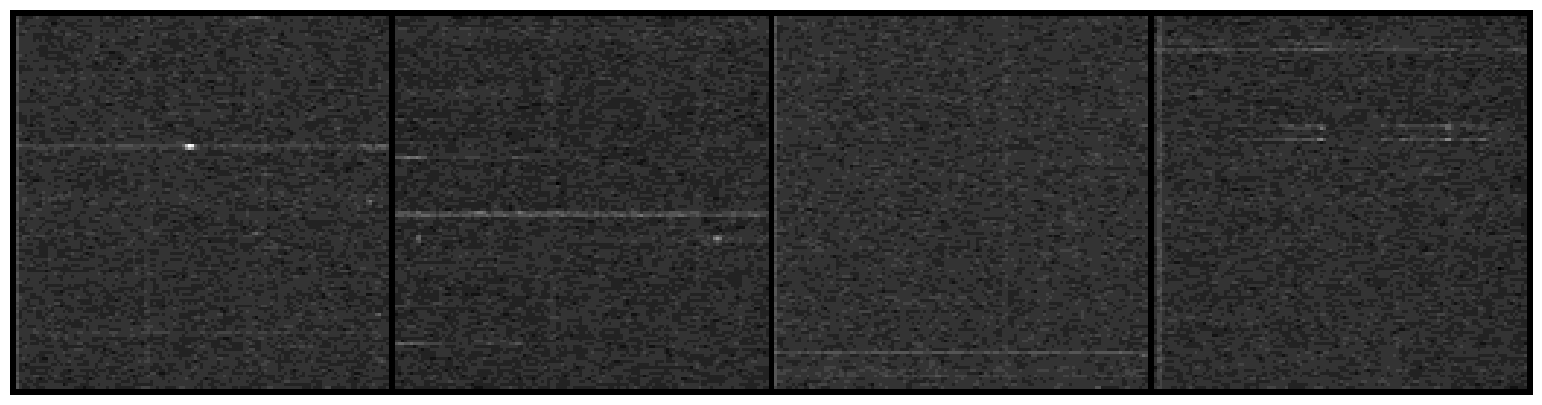

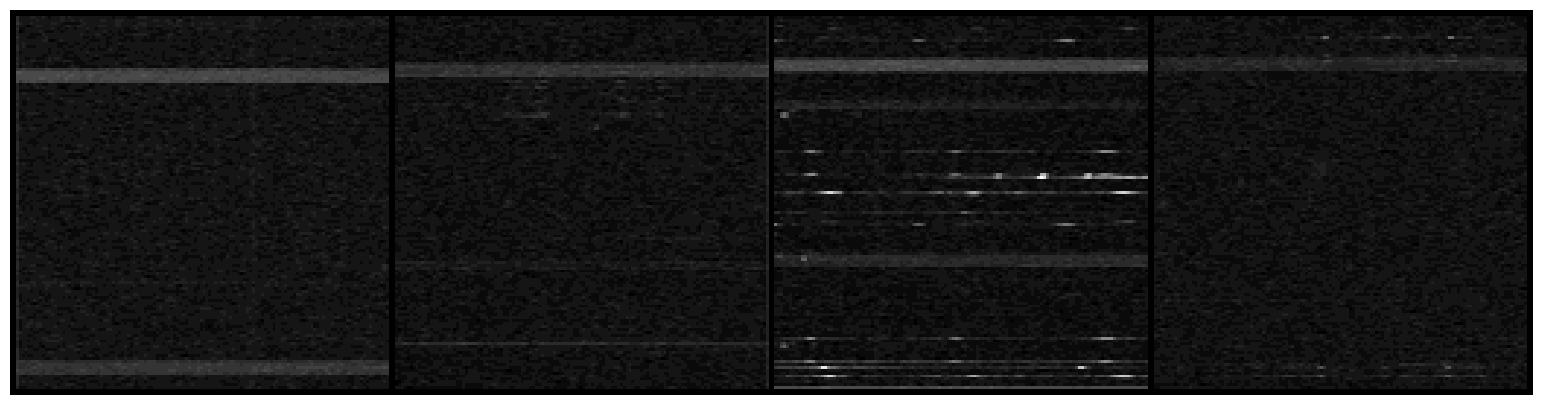

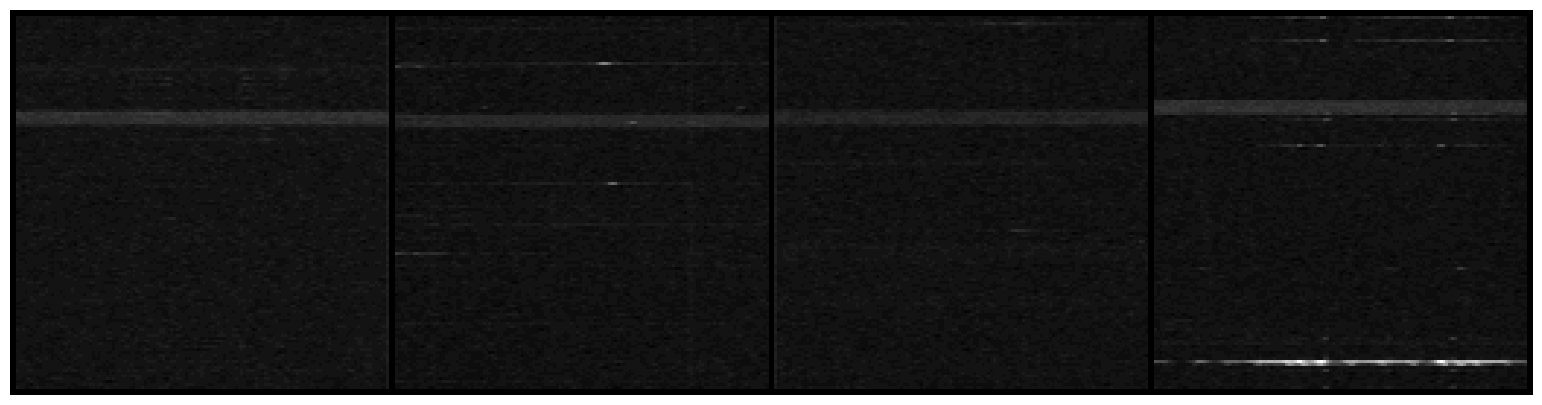

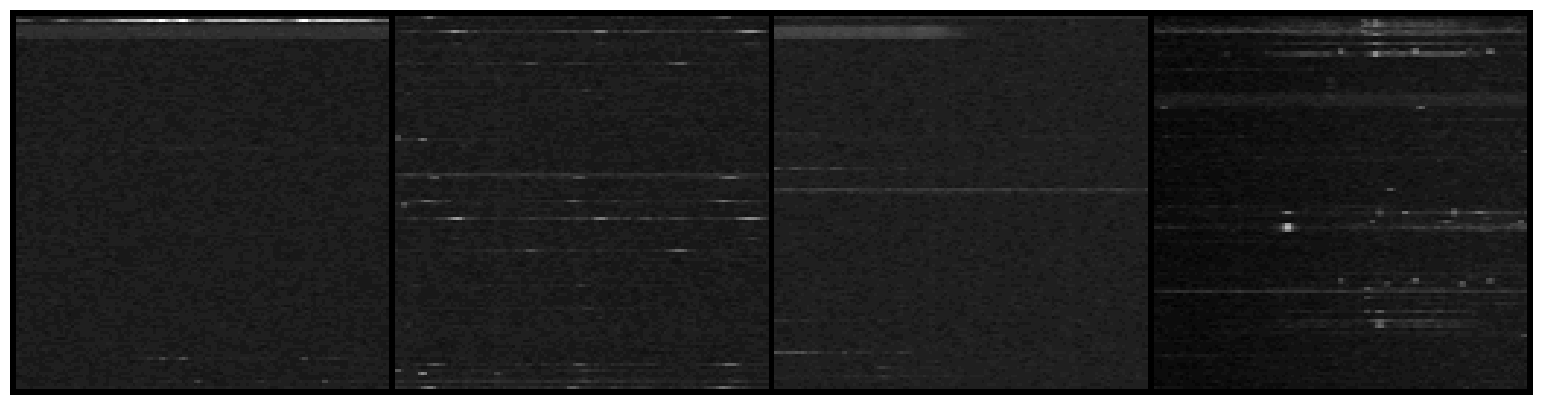

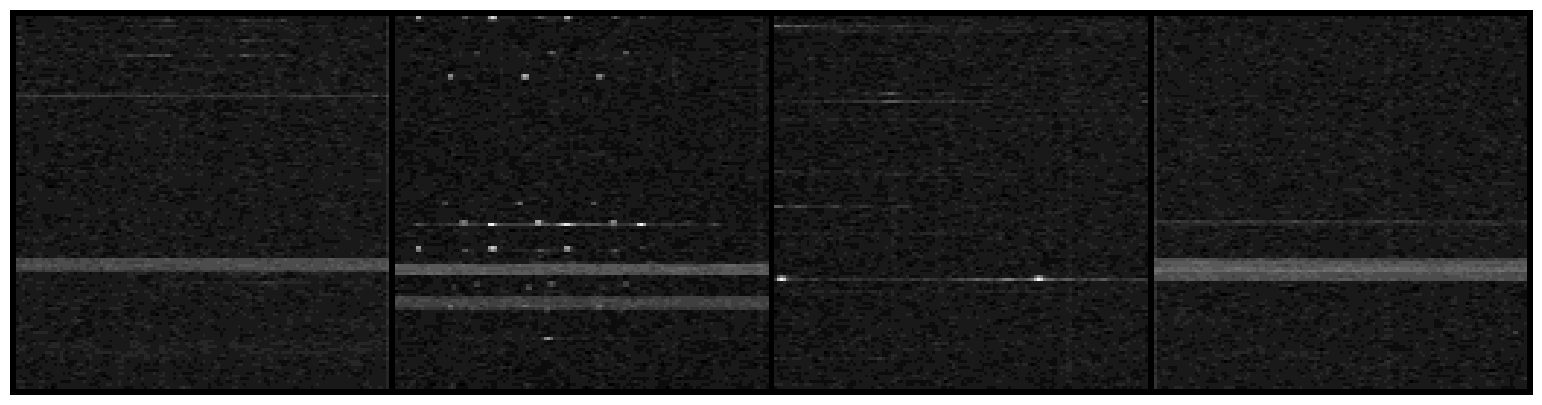

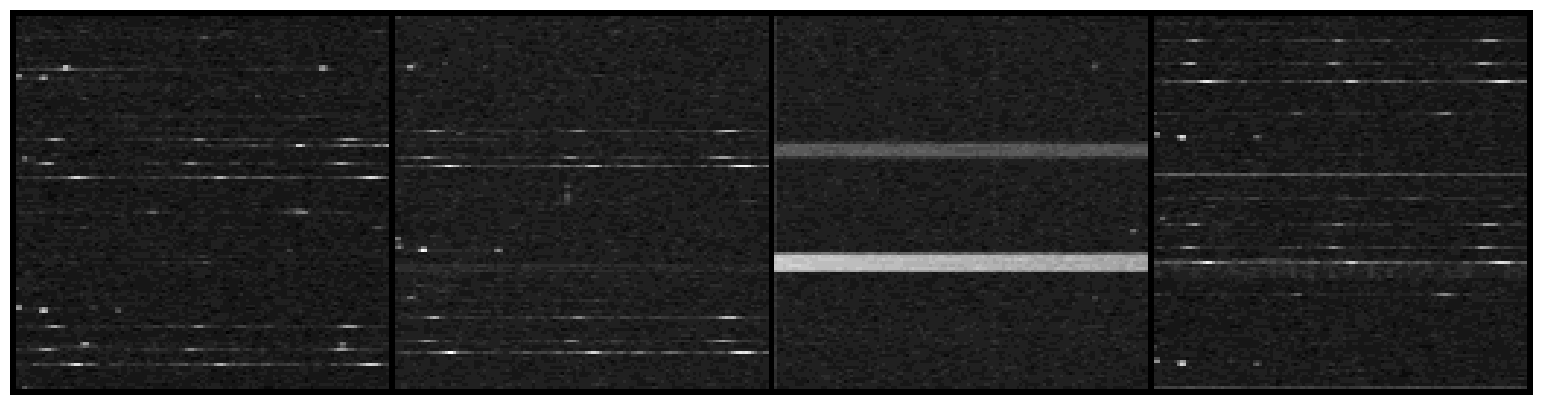

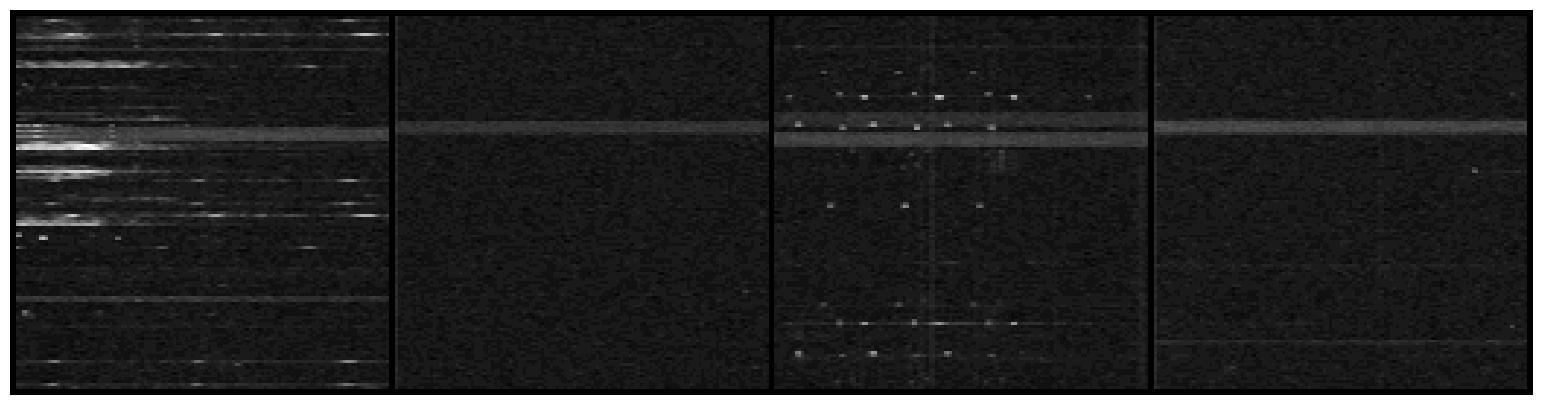

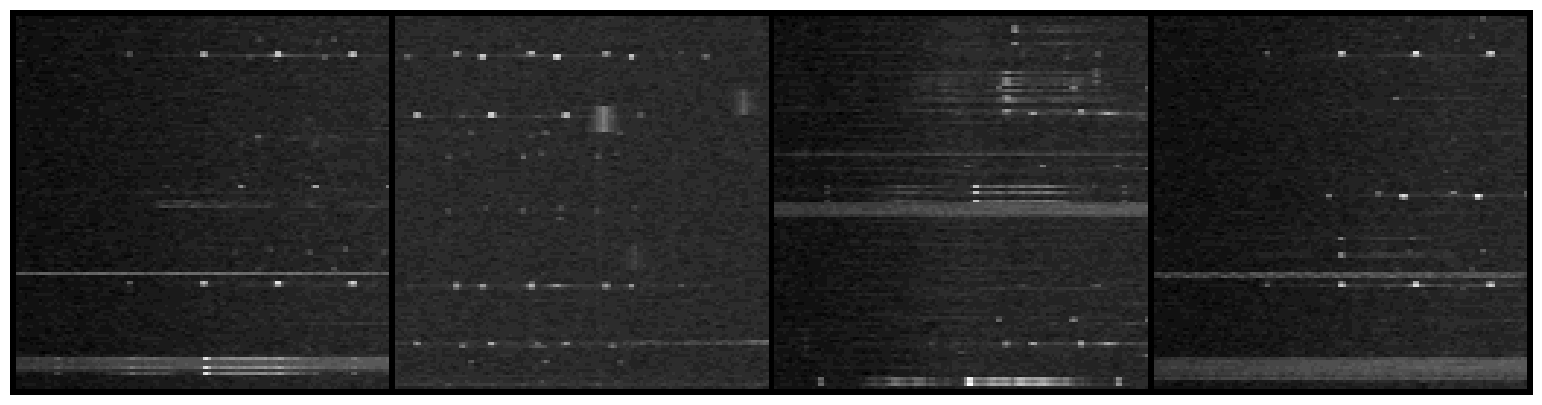

In [ ]:
# Show random sample from each cluster and table of stats.
plt.rc('font', size=24)
# plt.figure(figsize=(10, 5))
counts = Counter(pseudo_labels)
table = PrettyTable()
table.field_names = ["Cluster", "Number of images", "Minimum sample distance", "Maximum sample distance",
                     "Mean samples distance"]
num_images = 4
utls.set_all_seed(42)
num_components_to_use = 25

# Iterate for each cluster
for i in range(KMEANS_CLUSTERS):
  
    utls.show_cluster(cluster_centers, reduced[:, 0:PCA_DIM], counts.most_common()[i][0], pseudo_labels, 
              nn_input, limit=num_images, normalize=True)
  
    # Calculate min, max and meand distance of the given samples to the 
    # coresponding cluster.
    cluster_stats = utls.calc_cluster_stats(cluster_centers, pseudo_labels, reduced[:, 0:PCA_DIM], 
                                     counts.most_common()[i][0])
  
    # Put stats in table for better visualization.
    table.add_row([counts.most_common()[i][0], 
                 counts.most_common()[i][1],
                 '{0:.7f}'.format(min(cluster_stats)), 
                 '{0:.7f}'.format(max(cluster_stats)), 
                 '{0:.7f}'.format(sum(cluster_stats)/len(cluster_stats))])
    table_data = table.get_string()
    with open(RESULTS_PATH + 'c' + str(KMEANS_CLUSTERS) + 'pca' + str(PCA_DIM) \
            + 'table.txt', 'w') as f:
        f.write(table_data)

print(table)

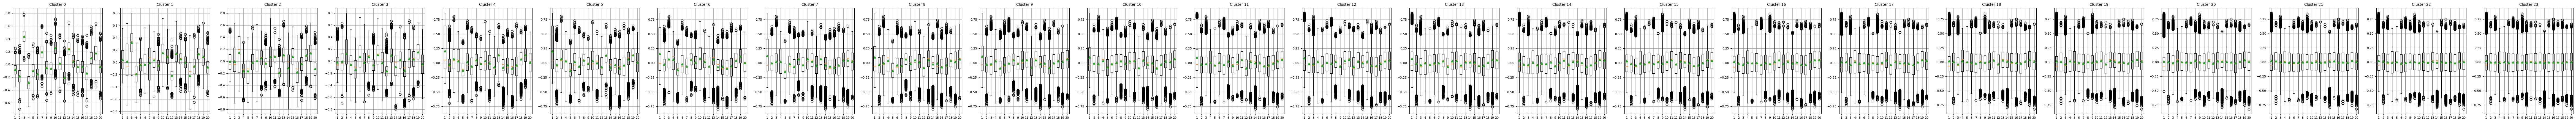

In [24]:
# Take one cluster and calculate mean of features of the assigned samples
used_features = reduced
plt.rc('font', size=8)
selected = []
result_data = []
width = 0.15
x_pos = [x / 10.0 for x in range(-5, PCA_DIM*10-5, 10)]
fig, axs = plt.subplots(1, KMEANS_CLUSTERS, figsize=(120,5))

for cluster in range(KMEANS_CLUSTERS):
    labels = np.array(pseudo_labels)
    indices = np.where(labels==cluster)[0]
    for i in indices:
        selected.append(used_features[i])

    selected_array = np.vstack(selected)
    selected_avg = np.mean(selected_array, axis=0)
    result_data.append(selected_avg)
    x_pos = [x+width for x in x_pos]

    axs[cluster].boxplot(selected_array, showmeans=True)
    axs[cluster].set_title("Cluster " + str(cluster))
    axs[cluster].grid()

plt.savefig(RESULTS_PATH + "stats c" + str(NUM_CLASSES) + ".png",
            facecolor='w', bbox_inches='tight', pad_inches = 0)
plt.show()